###  The code in this notebook can be used to replicate:
    1. Figure 1
    2. Extended Data Figure 1
    3. Supplemental Figures 1-4
    
    
#### Decode pipeline output files (provided in https://drive.google.com/drive/folders/1fz9QbWfl5JxM6HdYedPqg4sc5_K4yx7j?usp=sharing or generated by rerunning pipeline https://github.com/SlavovLab/decode/tree/main/decode_pipeline) required: 
    1. "sample_map.xlsx" for each CPTAC dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    2. "proteomic_tissue_list.txt" for Healthy dataset (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    3. "DP_search_evidence_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline) 
    4. "DP_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    5. "MTP_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    6. "PTM_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    7. "qMTP_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    8. "genome_substr_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    9. "Ion_validated_MTP_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    10. "Dataset_metrics.xlsx" (in pipeline_output/analysis_dependencies)
    11. "Modifications_dict.p" (in pipeline_output/analysis_dependencies)
    12. "msms.txt" for each TMT set/sample in each dataset (in pipeline_output/[dataset]/MQ_output/Validation_search/[sample]/txt)
        a. MQ output data for each sample must be unzipped after downloading
    13. "Validation_search_evidence_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    14. "Validated_MTP_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    15. "Rescoring.csv" (in pipeline_output/analysis_dependencies)
    
     ---------------------------------------------------------------------------------------------------------
16 - 19 only needed if reading in new output from decode pipeline. Used to generate files 20-22 which are provided in pipeline_output/HealthyTissues/AA_subs_pipeline. ---
    
    16. "tonsil_MTP.fasta" (in pipeline_output/HealthyTissues/databases)
    17. "tonsil_MTP_quant_dict_newvalsearch.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    18. "tonsil_Ion_validated_MTP_dict_newvalsearch.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    19. "tonsil_Validation_search_evidence_dict.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    ---------------------------------------------------------------------------------------------------------
    
    20. "Tonsil_SAAP_dict.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    21. "Tonsil_BP_dict.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    22. "all_tonsil_mainpeps_in_prots_newval_search.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    23. "seq_cov_frac.p" (in pipeline_output/analysis_dependencies)
    24. "All_SAAP_protein_filter_df_w_KR_AAS.xlsx" (in pipeline_output/analysis_dependencies)
    
    25. "Position_probability_fragment_ion_data.csv" (in pipeline_output/analysis_dependencies; also generated here)
    26. "Fragment_ion_dict.p" (in pipeline_output/analysis_dependencies; also generated here)
    27. "[Dataset]_SAAP_predictions.csv" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline; also can be generated with code supplied here)
    28. "[Dataset]_BP_predictions.csv" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline; also can be generated with code supplied here)
    29. "Supplemental_Data_3.SAAP_precursor_quant.xlsx"
    
*** It is highly recommended to maintain the same directory structure as in the Google Drive ***


The code in this notebook is organized and labeled by references to figures in the manuscript.

In [1]:
# read in packages needed
# install any missing packages using conda or pip 

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter
import scipy as sp
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import os
import ast
from scipy.odr import Model, RealData, ODR
from scipy.stats import gaussian_kde
from matplotlib import gridspec
#mport milkviz as mv
from matplotlib_venn import venn3
import zipfile
from glob import glob
import gzip
import tarfile
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import copy

#### Setting directories and reading in data.

Directories should be updated by the user to reflect where their output data from the decode pipeline and/or downloaded output data from project Google Drive is stored and where to store generated figures ("outdir")


"proj_dir" in the following chunk is the same directory structure as the Google Drive https://drive.google.com/open?id=15YoTBTZh4MdtAqHbibkYieEqyLyFi5hb&usp=drive_fs


In [2]:
proj_dir = os.getcwd()+'/'
dependencies_dir = proj_dir+'pipeline_output/analysis_dependencies/'
outdir = 'figures_testing/' # output directory where to save figures

# [dataset]_aa_subs_dir is the decode pipeline output folder
ccrcc_proj_dir = dependencies_dir+'CCRCC/'
ccrcc_aa_subs_dir = ccrcc_proj_dir+'AA_subs_pipeline/'
ccrcc_sample_map = pd.read_excel(ccrcc_aa_subs_dir+'sample_map.xlsx')
ccrcc_samples = ['S'+str(i) for i in list(set(ccrcc_sample_map['TMT plex']))]

ucec_proj_dir = dependencies_dir+'UCEC/'
ucec_aa_subs_dir = ucec_proj_dir+'AA_subs_pipeline/'
ucec_sample_map = pd.read_excel(ucec_aa_subs_dir+'sample_map.xlsx')
ucec_samples = ['S'+str(i) for i in list(set(ucec_sample_map['TMT plex']))]

brca_proj_dir = dependencies_dir+'BRCA/'
brca_aa_subs_dir = brca_proj_dir+'AA_subs_pipeline/'
brca_sample_map = pd.read_excel(brca_aa_subs_dir+'sample_map.xlsx')
brca_samples = ['S'+str(i) for i in list(set(brca_sample_map['TMT plex']))]

luad_proj_dir = dependencies_dir+'LUAD/'
luad_aa_subs_dir = luad_proj_dir+'AA_subs_pipeline/'
luad_sample_map = pd.read_excel(luad_aa_subs_dir+'sample_map.xlsx')
luad_samples = ['S'+str(i) for i in list(set(luad_sample_map['TMT plex']))]

pdac_proj_dir = dependencies_dir+'PDAC/'
pdac_aa_subs_dir = pdac_proj_dir+'AA_subs_pipeline/'
pdac_sample_map = pd.read_excel(pdac_aa_subs_dir+'sample_map.xlsx')
pdac_samples = ['S'+str(i) for i in list(set(pdac_sample_map['TMT plex']))]

lscc_proj_dir = dependencies_dir+'LSCC/'
lscc_aa_subs_dir = lscc_proj_dir+'AA_subs_pipeline/'
lscc_sample_map = pd.read_excel(lscc_aa_subs_dir+'sample_map.xlsx')
lscc_samples = ['S'+str(i) for i in list(set(lscc_sample_map['TMT plex']))]

wang_proj_dir = dependencies_dir+'HealthyTissues/'
wang_data_dir = wang_proj_dir+'AA_subs_pipeline/'
wang_samples = open(wang_data_dir+'proteomic_tissue_list.txt', 'r').read().split('\n')
wang_samples = [x for x in wang_samples if x!='rectum']

# lists used to quickly index dataset-specific sample maps (e.g.) from just the dataset name
datasets = ['CCRCC', 'UCEC', 'BRCA', 'LUAD', 'PDAC', 'LSCC', 'Healthy']
data_dir_list = [ccrcc_aa_subs_dir, ucec_aa_subs_dir, brca_aa_subs_dir, luad_aa_subs_dir, pdac_aa_subs_dir, lscc_aa_subs_dir, wang_data_dir]
samples_list = [ccrcc_samples, ucec_samples, brca_samples, luad_samples, pdac_samples, lscc_samples, wang_samples]
sample_map_list = [ccrcc_sample_map, ucec_sample_map, brca_sample_map, luad_sample_map, pdac_sample_map, lscc_sample_map]
proj_dir_list = [ccrcc_proj_dir, ucec_proj_dir, brca_proj_dir, luad_proj_dir, pdac_proj_dir, lscc_proj_dir, wang_proj_dir]


In [3]:
# functions used for figure formatting

class GridShader():
    """
    function used to create alternating vertical gray and white background in plots
    """
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks, [xlim[-1]]]))

        start = [x-0.5 for x in locs[1-int(self.sf)::2]]
        end = [x-0.5 for x in locs[2-int(self.sf)::2]]

        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))


def bihist(y1, y2, nbins=10, h=None):
    '''
    Function used to create violin plots as bihistograms with no smoothing.
    h is an axis handle. If not present, a new figure is created.
    '''
    if h is None: h = plt.figure().add_subplot(111)
    ymin = np.floor(np.minimum(min(y1), min(y2)))
    ymax = np.ceil(np.maximum(max(y1), max(y2)))
    bins = np.linspace(ymin, ymax, nbins)
    n1, bins1, patch1 = h.hist(y1, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    n2, bins2, patch2 = h.hist(y2, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    # set xmax:
    xmax = 0
    for i in patch1:
        i.set_edgecolor(None)
        width = i.get_width()
        if width > xmax: xmax = width
    # invert second histogram and set xmin:
    xmin = 0
    for i in patch2:
        i.set_edgecolor(None)
        width = i.get_width()
        width = -width
        i.set_width(width)
        if width < xmin: xmin = width
    h.set_xlim(xmin*1.1, xmax*1.1)          
    h.figure.canvas.draw()

# Figure 1. SAAP detection

#### Incl. Extended Data Figure 1

### Fig1a. N peptide IDs through filtering steps, from all DP to validated SAAP. Data used in generating Fig1a in biorender.

In [12]:
# get number of samples in each dataset
n_samples_data = []
total = 0
for ds in datasets:
    if ds!='Healthy':
        sample_map = sample_map_list[datasets.index(ds)]
        samples = sample_map['sample_name'].values
    else:
        samples = samples_list[datasets.index(ds)] 
    n_samples = len(samples)
    total += n_samples
    n_samples_data.append([ds, n_samples])
    print(ds, n_samples)
print(total)
n_samples_df = pd.DataFrame(n_samples_data, columns=['Dataset', 'N samples'])
n_samples_df.to_excel(outdir+'N_samples_in_datasets.xlsx')

CCRCC 194
UCEC 144
BRCA 122
LUAD 215
PDAC 207
LSCC 188
Healthy 26
1096


In [ ]:
def get_filter_df(data_dir, samples):
    """ function that reads in output from decode pipeline to get number of peptides in each category
    Input: directory with output files for dataset, dataset samples/TMT set names
    output: dataframe with the number of peptides in each category used to create fig 1a, c
    """
    dp_ev_dict = pickle.load(open(data_dir+'DP_search_evidence_dict.p', 'rb'))
    dp_dict = pickle.load(open(data_dir+'DP_dict.p', 'rb'))
    mtp_dict = pickle.load(open(data_dir+'MTP_dict.p', 'rb'))
    ptm_dict = pickle.load(open(data_dir+'PTM_dict.p', 'rb'))
    hc_mtp_dict = pickle.load(open(data_dir+'qMTP_dict.p', 'rb')) # dictionary of putative substitutions that pass FDR correction
    substr_dict = pickle.load(open(data_dir+'genome_substr_dict.p', 'rb'))
    val_mtp_dict = pickle.load(open(data_dir+'Ion_validated_MTP_dict.p','rb'))
    
    rows = []
    for s in samples:
        seqs = [[x for y in list(mtp_dict[s]['mistranslated sequence'].values()) for x in y] for s in samples]
        seqs = [x for y in seqs for x in y]
        if 'all_6frame_seqs' in substr_dict.keys():
            homolog_seqs = substr_dict['all_6frame_seqs']
        else:
            homolog_seqs = substr_dict['all_frame6_seqs']
        seqs_hom = [x for x in seqs if x in homolog_seqs]
        
        n_main = len(dp_ev_dict[s]['Raw file'])
        n_dp = len(dp_dict[s]['Raw file'])
        n_ptm = len(ptm_dict[s]['Raw file'])
        n_aas = len(mtp_dict[s]['Raw file'])
        n_nohom = len([i for i,x in mtp_dict[s]['mistranslated sequence'].items() if all(y not in seqs_hom for y in x)])
        n_hc = len([i for i,x in hc_mtp_dict[s]['mistranslated sequence'].items() if all(y not in seqs_hom for y in x)])
        n_val = len(val_mtp_dict[s]['Raw file'])

        rows.append([s, n_main, n_dp, n_ptm, n_aas, n_nohom, n_hc, n_val])
    df = pd.DataFrame(rows, columns=['TMT set', 'Main peptides', 'DP', 'PTM', 'AAS', 'Non-homologous', 'High-confidence', 'Validated'])

    return(df)

In [9]:
# create a dictionary containing the dataframes generated with the above function for each dataset
filter_dict = {}
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    samples = samples_list[datasets.index(ds)]
    filter_dict[ds] = get_filter_df(data_dir, samples)

for ds in datasets:
    filter_dict[ds]['Dataset'] = [ds]*len(filter_dict[ds])
pickle.dump(filter_dict, open(outdir+'Modified_peptide_filter_dict_DP2valSAAP.p', 'wb'))

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


#### print numbers needed for figure 1A - all datasets
1. Total N DP 
2. Total N match to AAS
3. Total N match to AAS and not genome
4. Total N match to AAS, not genome and high confidence
5. Total N validated

In [10]:
#filter_dict = pickle.load(open(outdir+'Modified_peptide_filter_dict_DP2valSAAP.p', 'rb'))
all_df = pd.concat([filter_dict[ds] for ds in datasets])

sum_dict = {}
for col in all_df.columns:
    if col not in ['TMT set', 'Dataset', 'Tissue']:
        sum_dict[col] = np.nansum(all_df[col].values)
        
print(sum_dict) # these values are used in 1a

{'Main peptides': 30070979, 'DP': 8849475, 'PTM': 3212535, 'AAS': 124380, 'Non-homologous': 123896, 'High-confidence': 118962, 'Validated': 60803}


### Figure 1c. Filtering modified peptides to candidate SAAP

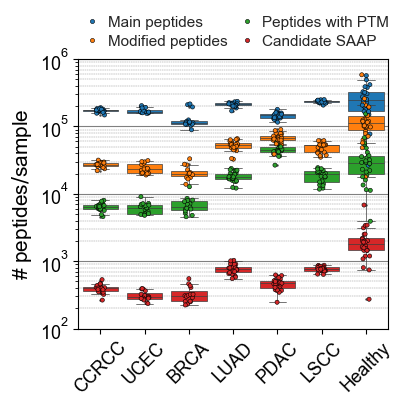

In [20]:
boxplot_rows = []
for i,row in all_df.iterrows():
    boxplot_rows.append([row['Dataset'], row['Main peptides'], 'Main peptides', row['TMT set']])
    boxplot_rows.append([row['Dataset'], row['DP'], 'Dependent peptides', row['TMT set']])
    boxplot_rows.append([row['Dataset'], row['PTM'], 'Peptides with PTM', row['TMT set']])
    #boxplot_rows.append([row['Dataset'], row['AAS'], 'Peptides with AAS', row['TMT set']])
    #boxplot_rows.append([row['Dataset'], row['Non-homologous'], 'Non-homologous AAS', row['TMT set']])
    boxplot_rows.append([row['Dataset'], row['High-confidence'], 'High-confidence AAS', row['TMT set']])
    
boxplot_df = pd.DataFrame(boxplot_rows, columns=['Dataset','N peptide IDs', 'Peptide type', 'TMT set'])

fig,ax = plt.subplots(figsize=(4,3.5))
sns.set_style('whitegrid')
plt.grid(True,which="major",c='gray')  
plt.grid(True,which="minor",ls="--",c='gray', linewidth=0.3)  

sns.stripplot(data= boxplot_df, x='Dataset', y='N peptide IDs', hue='Peptide type',dodge=False,s=3, linewidth=0.4, edgecolor='k')
sns.boxplot(data= boxplot_df, x='Dataset', y='N peptide IDs', hue='Peptide type', dodge=False, linewidth=0.5, fliersize=0.7, saturation=1)
plt.yscale('log')
plt.ylim([100,10**6])
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('# peptides$/$sample', fontsize=15)
plt.xlabel('')
handles, labels = ax.get_legend_handles_labels()
custom_labels = ['Main peptides', 'Modified peptides', 'Peptides with PTM','Candidate SAAP']
plt.legend(handles=handles[0:], labels=custom_labels, bbox_to_anchor=(0.5,1.1), fontsize=11, ncol=2, labelspacing=0.3, handletextpad=0, frameon=False, columnspacing=0.3, loc='center');
plt.savefig(outdir+'Dataset_filtering_boxplot_wmainpeptides.pdf', bbox_inches='tight')

### Fig 1D. PTMs

In [21]:
def get_ptm_df(ptm_dict, ds):
    """
    function to get a dataframe of PTMS x datasets from the datasets' PTM_dict.p
    """
    master_ptm_list = []
    for s,v in ptm_dict.items():
        s_ptm_dict = v['PTM']
        for ptm_list in s_ptm_dict.values():
            new_ptm_list = [x for x in ptm_list if x not in master_ptm_list]
            new_ptm_list = list(set(new_ptm_list))
            master_ptm_list = master_ptm_list + new_ptm_list

    heatmap_df = pd.DataFrame(index=master_ptm_list, columns=list(range(1,24)))
    for s, v in ptm_dict.items():
        if ds !='Healthy':
            s_int = int(s[1:])
        else:
            s_int=s
        ptm_list = list(v['PTM'].values())
        ptm_list = [x for y in ptm_list for x in y]
        ptm_count = Counter(ptm_list)
        for ptm, count in ptm_count.items():
            heatmap_df.loc[ptm, s_int] = count
            #heatmap_df.loc[ptm, s_int] = np.log10(count)
    heatmap_df.fillna(0, inplace=True)
    return(heatmap_df)


In [22]:
# get PTM dataframe for each dataset
for i in range(len(datasets)):
    print(datasets[i])
    data_dir =  data_dir_list[i]
    ptm_dict = pickle.load(open(data_dir+'PTM_dict.p', 'rb'))
    heatmap_df = get_ptm_df(ptm_dict, ds)
    heatmap_df.to_excel(data_dir+'PTM_heatmap_df.xlsx')
    
# create a dictionary with the PTM dataframes for each dataset
ptm_heatmap_dict = {}
for i,ds in enumerate(datasets):
    data_dir = data_dir_list[i]
    ptm_df = pd.read_excel(data_dir + 'PTM_heatmap_df.xlsx', index_col=0)
    ptm_df['avg'] = [np.mean(row.values) for i,row in ptm_df.iterrows()]
    ptm_df.sort_values('avg', ascending=False, inplace=True) # sort by frequency to extract top PTMs for plot
    
    ptm_df.index = [x[0].upper()+x[1:] for x in ptm_df.index]
    ptm_heatmap_dict[ds] = ptm_df
    
pickle.dump(ptm_heatmap_dict, open(outdir+'PTM_heatmap_dict.p', 'wb'))
#ptm_heatmap_dict = pickle.load(open(nofilter_outdir+'PTM_heatmap_dict.p', 'rb'))


# extract the top PTMs by frequency into a dataframe for plotting
top20 = []
for ds, ds_df in ptm_heatmap_dict.items():
    if len(top20)==0:
        top20 = ds_df.index.values[0:40]
    else:
        top20new = ds_df.index.values[0:40]
        top20 = [x for x in top20 if x in top20new]
plot_df = pd.DataFrame(index=top20, columns=datasets)
for ptm in top20:
    for ds in datasets:
        heatmap_df = ptm_heatmap_dict[ds]
        plot_df.loc[ptm,ds] = heatmap_df.loc[ptm,'avg']
plot_df = plot_df.astype(float)

# need number of peptides IDd to normalize N each PTM per 1000 peptides
ds_metrics= pd.read_excel(dependencies_dir+'Dataset_metrics.xlsx', index_col=0) # dataframe created externally with number of peptides identified in the main seach of each dataset
n_peptides_list = []
for ds in datasets:
    n_peptides = ds_metrics.loc[ds_metrics['Dataset']==ds, 'Peptides (evidence)'].values[0]
    n_peptides_list.append(n_peptides)

# normalize PTM plot df by per thousand peptides
scaled_plot_df = deepcopy(plot_df)
for i,ds in enumerate(datasets):
    scaled_plot_df[ds] = [x/(n_peptides_list[i]/1000) for x in scaled_plot_df[ds]]
scaled_plot_df.to_excel(outdir+'PTM_heatmap_data.xlsx')

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


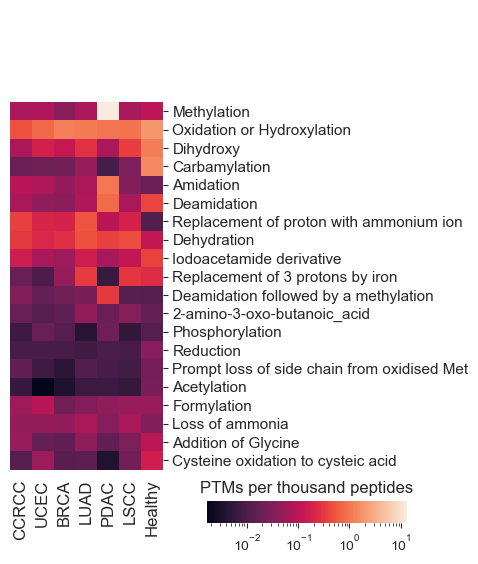

In [23]:
# plot PTM heatmap
cg = sns.clustermap(data=scaled_plot_df, yticklabels=True,norm=LogNorm(), cbar_kws={'orientation':'horizontal', 'ticks':[0.01,0.1,1,10]},
                    figsize=(5,5.5), cmap=sns.color_palette('rocket', as_cmap=True), method='ward', col_cluster=False, row_cluster=True)
cg.ax_cbar.set_title(r'PTMs per thousand peptides')
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=12)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=11)
x0, y0, w, h = cg.cbar_pos
cg.ax_cbar.set_position([0.5, 0.04, 0.4, 0.04])
cg.ax_row_dendrogram.set_visible(False)
plt.savefig(outdir+'PTM_heatmap_top20.pdf', bbox_inches='tight')

### Extended data figure 1e.  Types of modifications identified (PTM, chemical, etc.)

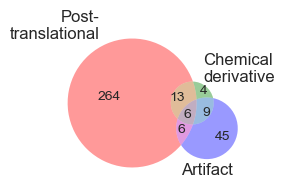

In [24]:
all_PTMs = []
for ds, ptm_df in ptm_heatmap_dict.items():
    ds_ptms = list(ptm_df.index)
    all_PTMs = all_PTMs + ds_ptms
set_PTMs = list(set(all_PTMs))

# create a dictionary with the classification of each modification type
mod_class_dict = {}
mod_list =  pickle.load(open(dependencies_dir+'Modifications_dict.p', 'rb')) # derived from Unimod database
for mod_dict in mod_list:
    mod_name = mod_dict['Description']
    class_keys = [x for x in mod_dict if 'classification' in x]
    classes = [mod_dict[k] for k in class_keys if mod_dict[k]!=['Multiple']]
    classes = list(set([x if 'glycosylation' not in x else 'Post-translational' for x in classes]))
    mod_class_dict[mod_name.lower()] = classes

# get the number of modifications pertaining to each class
ptm_ptms = []
chemical_ptms = []
artifact_ptms = []
ptm_or_chemical_ptms = []
chem_or_artifact_ptms = []
ptm_or_artifact_ptms = []
alltypes_ptms = []

for i,ptm in enumerate(set_PTMs):
    if 'TMT' not in ptm:
        ptm = ptm.lower()
        ptm_class = mod_class_dict[ptm]
        if 'Post-translational' in ptm_class:
            if len(ptm_class)==1:
                ptm_ptms.append(ptm)
            elif 'Chemical derivative' in ptm_class and 'Artefact' in ptm_class:
                alltypes_ptms.append(ptm)
            elif 'Chemical derivative' in ptm_class:
                ptm_or_chemical_ptms.append(ptm)
            elif 'Artefact' in ptm_class:
                ptm_or_artifact_ptms.append(ptm)

        elif 'Chemical derivative' in ptm_class:
            if len(ptm_class)==1:
                chemical_ptms.append(ptm)
            elif 'Artefact' in ptm_class:
                chem_or_artifact_ptms.append(ptm)
        elif 'Artefact' in ptm_class:
            artifact_ptms.append(ptm)
    else:
        chemical_ptms.append(ptm)

n_ptms = len(ptm_ptms)
n_chemical_dervs = len(chemical_ptms)
n_artifacts = len(artifact_ptms)
n_ptm_chem = len(ptm_or_chemical_ptms)
n_chem_artifact = len(chem_or_artifact_ptms)
n_ptm_artifact = len(ptm_or_artifact_ptms)
n_any = len(alltypes_ptms)

# plot the Venn diagram
fig,ax = plt.subplots(figsize=(3,2))
v = venn3(subsets = (n_ptms, n_chemical_dervs, n_ptm_chem, n_artifacts, n_ptm_artifact, n_chem_artifact, n_any),
         set_labels = ('Post-\ntranslational', 'Chemical\nderivative', 'Artifact'), ax=ax)
plt.savefig(outdir+'PTM_source.pdf', bbox_inches='tight')


### Extended Data Figure 1a,b. N samples per dataset

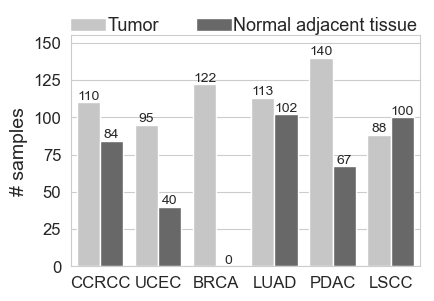

In [25]:
# get the number of samples in each CPTAC dataset and plot

plot_rows = []
plot_cols = ['Dataset', 'N samples', 'Sample type']
for ds in datasets[:-1]:
    sample_map = sample_map_list[datasets.index(ds)]
    n_t_samples = len(sample_map.loc[sample_map['Group']=='Tumor'])
    n_n_samples = len(sample_map.loc[sample_map['Group']=='Normal'])
    plot_rows.append([ds, n_t_samples, 'Tumor'])
    plot_rows.append([ds, n_n_samples, 'Normal adjacent tissue'])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(4.5,3))
sns.barplot(data=plot_df, x='Dataset', y='N samples', hue='Sample type', palette=sns.color_palette(palette='Greys', n_colors=2))
ax.tick_params('both', labelsize=12)
plt.xlabel('')
plt.ylabel('# samples', fontsize=14)
plt.ylim([0,155])
plt.yticks([0,25,50,75,100,125,150])
plt.bar_label(plt.gca().containers[0])
plt.bar_label(plt.gca().containers[1])
plt.legend(ncol=2, bbox_to_anchor=(1.04,1.15), frameon=False, fontsize=13, handletextpad=0.1)
plt.savefig(outdir+'CPTAC_N_samples_per_dataset.pdf', bbox_inches='tight')

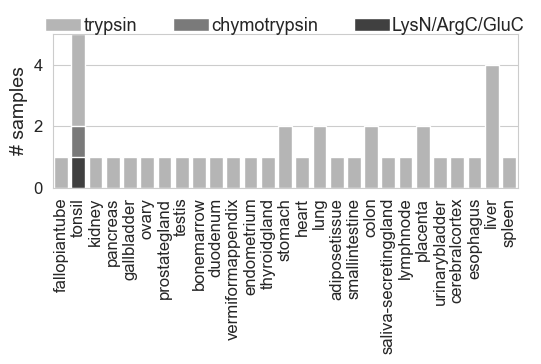

In [26]:
# get the number of samples in each healthy tissue and plot

plot_rows = []
plot_cols = ['Tissue', 'N samples', 'Protease']
for sample in wang_samples:
    n = 1
    protease = 'trypsin'
    if sample == 'liver':
        n = 4
    elif sample == 'colon' or sample == 'placenta' or sample == 'lung' or sample == 'stomach' :
        n = 2
    plot_rows.append([sample, n, protease])
    plot_rows.append(['tonsil', 5, 'trypsin'])
    plot_rows.append(['tonsil', 2, 'chymotrypsin'])
    plot_rows.append(['tonsil', 1, 'LysN/ArgC/GluC'])
    #plot_rows.append(['tonsil', 1, 'GluC'])
    #plot_rows.append(['tonsil', 1, 'ArgC'])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(6,2))
#fig,axes = plt.subplots(1,2, figsize=(8,3), sharey=True, gridspec_kw={'width_ratios':[4,1]})
plt.subplots_adjust(wspace=0.03)

sns.barplot(data=plot_df, x='Tissue', y='N samples', hue='Protease', dodge=False, palette=sns.color_palette(palette='Greys', n_colors=4)[1:])
ax.tick_params('both', labelsize=12)
ax.tick_params('x', rotation=90)
ax.set_xlabel('')
ax.set_ylabel('# samples', fontsize=14)
ax.set_ylim([0,5])
plt.legend(ncol=3, bbox_to_anchor=(0.5,1.05), frameon=False, fontsize=13, loc='center', handletextpad=0.1)

    
plt.savefig(outdir+'Healthy_N_samples_per_dataset.pdf', bbox_inches='tight')

### Extended Data Figure 1f. Mass shifts of SAAP and main peptides

In [27]:
# read in DP_dicts for all datasets and extract delta mass, plot
# get deltaM from Ion_validated_MTP_dicts.p

deltaM_dict = {}
saap_deltaM_dict = {}

# function to get mass shifts of all dependent peptides
def get_deltaMs(dp_dict, samples):
    deltaM_list = []
    for s in samples: 
        s_dict = dp_dict[s]
        deltaMs = list(s_dict['DP Mass Difference'].values())
        deltaM_list = deltaM_list + deltaMs
    return(deltaM_list)

# function to get mass shifts of dependent peptides corresponding to SAAP
def get_SAAP_deltaMs(saap_dict, samples):
    saap_deltaM_list = []
    for s in samples: 
        s_dict = saap_dict[s]
        deltaMs = list(s_dict['DP Mass Difference'].values())
        saap_deltaM_list = saap_deltaM_list + deltaMs   
    return(saap_deltaM_list)

# get mass shifts for DP and SAAP in each dataset
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    samples = samples_list[datasets.index(ds)]
    dp_dict = pickle.load(open(data_dir+'DP_dict.p', 'rb'))
    saap_dict = pickle.load(open(data_dir+'Ion_validated_MTP_dict.p', 'rb'))

    deltaMs = get_deltaMs(dp_dict, samples)
    saap_deltaMs = get_SAAP_deltaMs(saap_dict, samples)
    deltaM_dict[ds] = deltaMs
    saap_deltaM_dict[ds] = saap_deltaMs

# combine data from all datasets
deltaMs = list(deltaM_dict.values())
saap_deltaMs = list(saap_deltaM_dict.values())
deltaMs = [x for y in deltaMs for x in y]
saap_deltaMs = [x for y in saap_deltaMs for x in y]

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


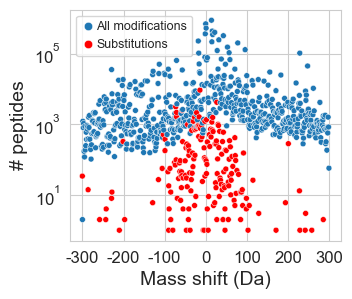

In [28]:

# Rank sort peptides by mass shift
deltaM_N_rows = []
deltaMs_round = [np.round(x,0) for x in deltaMs if np.abs(x)<=300]
deltaMs_counts = Counter(deltaMs_round)
[deltaM_N_rows.append([k,v, 'All modifications']) for k,v in deltaMs_counts.items()]
saap_deltaMs_round = [np.round(x, 1) for x in saap_deltaMs]
saap_deltaMs_counts = Counter(saap_deltaMs_round)
[deltaM_N_rows.append([k,v, 'Substitutions']) for k,v in saap_deltaMs_counts.items()]
deltaM_N_df = pd.DataFrame(deltaM_N_rows, columns=['deltaM', 'N', 'Type'])
deltaM_N_df.sort_values('deltaM', inplace=True)


# plot scatterplot of number of spectra observed with mass shift 
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(3.5,3))
sns.scatterplot(data=deltaM_N_df,x='deltaM', y='N', hue='Type',palette=[colors[0], 'red'], hue_order=['All modifications', 'Substitutions'], alpha=1, size=5)

plt.yscale('log')
plt.xticks([-300,-200,-100,0,100,200,300], labels=['-300', '-200', '-100','0','100','200','300'])
plt.ylabel('# peptides', fontsize=14)
plt.xlabel('Mass shift (Da)', fontsize=14)
ax.tick_params('both', labelsize=12)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['All modifications', 'Substitutions'], title='', fontsize=9, loc='upper left', handletextpad=0.2, handlelength=1)

plt.savefig(outdir+'deltaM_scatter_SAAP_higlighted.pdf', bbox_inches='tight')
plt.savefig(outdir+'deltaM_scatter_SAAP_higlighted.png', dpi=300, bbox_inches='tight')


### Extended Data Figure 1g. Mass errors of SAAP and main peptides

In [29]:
# generate a dictionary with mass error data
mass_err_dict = {ds:{'Main peptide mass error':[], 'SAAP mass error':[]} for ds in datasets}
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    mainpep_dict = pickle.load(open(data_dir+'DP_search_evidence_dict.p','rb'))
    samples = samples_list[datasets.index(ds)]
    for s in samples:
        errs = mainpep_dict[s]['Mass error [ppm]']
        errs = [x for x in errs if np.abs(x)<10000]
        mass_err_dict[ds]['Main peptide mass error'] = mass_err_dict[ds]['Main peptide mass error']+errs

pickle.dump(mass_err_dict, open(outdir+'Main_peptide_mass_error_ppm.p','wb'))
#mass_err_dict = pickle.load(open(outdir+'Main_peptide_mass_error_ppm.p','rb'))

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


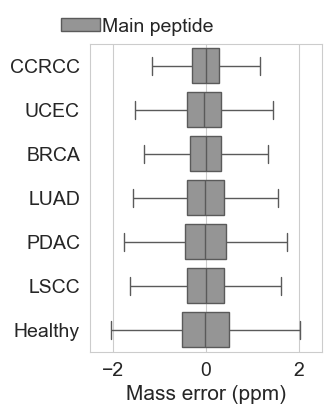

In [30]:
# plot mass error boxplots
plot_df_list = []
for ds in datasets:
    print(ds)
    ds_me_dict = mass_err_dict[ds]
    main_pep_errs = ds_me_dict['Main peptide mass error']
    #if ds!='UCEC':
    saap_errs = [np.abs(x) for x in ds_me_dict['SAAP mass error']]
    saap_errs = saap_errs + [-x for x in saap_errs]
    ds_list = [ds]*len(main_pep_errs+saap_errs)
    main_str_list = ['Main peptide']*len(main_pep_errs)
    saap_str_list = ['SAAP']*len(saap_errs)
    
    ds_plot_df = pd.DataFrame(zip(ds_list, main_pep_errs+saap_errs, main_str_list+saap_str_list), columns=['Dataset', 'Mass error (ppm)', 'Peptide type'])
    plot_df_list.append(ds_plot_df)
plot_df = pd.concat(plot_df_list)

fig,ax = plt.subplots(figsize=(3,4))
sns.boxplot(data=plot_df, y='Dataset', hue='Peptide type', x='Mass error (ppm)', linewidth=1, fliersize=0, palette='Greys')
plt.xlabel('Mass error (ppm)', fontsize=15)
ax.tick_params('both', labelsize=14)
plt.ylabel('')
plt.xlim([-2.5,2.5])
plt.legend(loc='lower left', fontsize=14, bbox_to_anchor=(-0.2,0.97), frameon=False, ncol=2, handletextpad=0.1, columnspacing=0.8)
plt.savefig(outdir+'Mass_error_boxplots.pdf', bbox_inches='tight')


### Figure 1f. Number of fragments covering site of substitution

In [ ]:
def n_frags_over_MTP(frag_match, mtp, sub_idx):
    """
    Input: fragment matches for peptide from msms.txt (MQ output file), peptide sequence, index of AAS on sequence
    Output: number of fragment ions covering site of AAS
    """
    count = 0
    for f, frag in enumerate(frag_match):
        mtp_frag=0
        if ('NH3' not in frag) and ('H2O' not in frag) and ('(' not in frag) and ('a' not in frag):
            if 'b' in frag:
                frag_start = 0
                frag_end = int(frag[1:])
                frag_seq = mtp[frag_start:frag_end]
                if frag_end>sub_idx:
                    mtp_frag = 1
            elif 'y' in frag:
                frag_start = -int(frag[1:])
                frag_seq = mtp[frag_start:]
                if len(mtp)+frag_start <= sub_idx:
                    mtp_frag=1
            count+=mtp_frag
        
    return(count)


In [ ]:
# add fragment evidence data to Validation_MTP_dict.p for each dataset 
""" only need to run this if regenerated Validated_MTP_dict.p using pipeline. 
If downloaded from Google Drive, dictionaries already contain fragment data"""

for ds in datasets:
    print(ds)

    data_dir = data_dir_list[datasets.index(ds)]
    mtp_dict = pickle.load(open(data_dir+'Validated_MTP_dict.p','rb'))
    val_evidence_dict = pickle.load(open(data_dir+'Validation_search_evidence_dict.p', 'rb'))
    MQ_dir = data_dir+'MQ_output/Validation_search'
    samples = samples_list[datasets.index(ds)]

    for s in samples:
        print(s)
       # if s not in done:
        ev = val_evidence_dict[s]
        with open(MQ_dir+'/'+s+'/txt/msms.txt') as msms_file:
            msms = pd.read_csv(msms_file, '\t', low_memory=False)
            msms_vals = msms.values

            mtp_dict[s]['fragment_evidence'] = {}
            for k,v in mtp_dict[s]['aa subs'].items():
                seq = mtp_dict[s]['mistranslated sequence'][k]
                bp = mtp_dict[s]['DP Base Sequence'][k]
                sub_idx = [i for i,x in enumerate(bp) if seq[i]!=x][0]

                ev_idx = mtp_dict[s]['idx_val_evidence'][k]
                mtp_dict[s]['fragment_evidence'][k] = 0
                for idx in ev_idx:
                    row = ev.iloc[idx,:]
                    raw_file = row['Raw file']
                    scan = row['MS/MS scan number']
                    scan_row_idx = [i for i in range(len(msms_vals)) if (msms_vals[i][0]==raw_file) and (msms_vals[i][1]==scan)]
                    #scan_row = msms.loc[(msms['Raw file']==raw_file) & (msms['Scan number']==scan),:]
                    if len(scan_row_idx)>0:
                        scan_row = msms.iloc[scan_row_idx[0]]
                        frag_match = scan_row['Matches'].split(';')
                        count_frags = n_frags_over_MTP(frag_match, seq, sub_idx)
                        if count_frags>mtp_dict[s]['fragment_evidence'][k]:
                            mtp_dict[s]['fragment_evidence'][k] = count_frags
        msms_file.close()
    pickle.dump(mtp_dict, open(data_dir+'Validated_MTP_dict.p','wb'))

In [40]:
# generate dataframe with fragment ion data
cats = ['0', '1','2-5','6-10','>10']
scan_counts = [0,0,0,0,0]
pep_counts = [0,0,0,0,0]

for ds in datasets[:-1]:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    samples = samples_list[datasets.index(ds)]
    mtp_dict = pickle.load(open(data_dir+'Validated_MTP_dict.p','rb'))

    for s in samples:
        s_dict = mtp_dict[s]
        for i,n in s_dict['fragment_evidence'].items():
            if n ==0:
                scan_counts[0]+=1
            elif n ==1:
                scan_counts[1]+=1
            elif (n >1) and (n <=5):
                scan_counts[2]+=1
            elif (n>5) and (n <=10):
                scan_counts[3]+=1
            else:
                scan_counts[4]+=1

plot_df = pd.DataFrame(zip(cats,scan_counts), columns=['Bin', 'Count'])
plot_df['Used'] = ['Yes' if row['Bin'] not in ['0','1'] else 'No' for i,row in plot_df.iterrows()]
plot_df.to_excel(outdir+'by_fragments_per_saap_4barplot_allDS.xlsx')

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC


Text(0.5, 0, '# peptide fragments supporting\nsubstitution site')

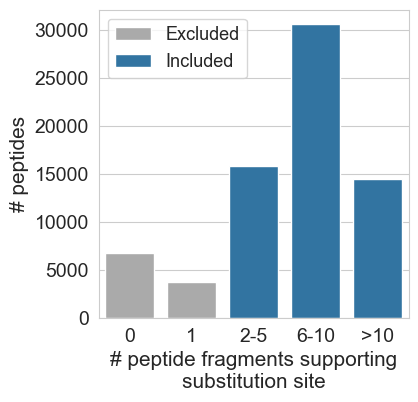

In [41]:
# plot n fragments barplots
plot_df = pd.read_excel(dependencies_dir+'by_fragments_per_saap_4barplot_allDS.xlsx', index_col=0)

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(4,4))
sns.barplot(data = plot_df, x='Bin', y='Count', hue='Used',dodge=False, palette=['#aaaaaa',colors[0]])   
ax.tick_params('both',labelsize=14)

plt.ylabel('# peptides', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,loc='upper left', labels=['Excluded', 'Included'], fontsize=13)
plt.xlabel('# peptide fragments supporting\nsubstitution site', fontsize=15)
#plt.savefig(outdir+'fragment_ion_evidence_barplot_allDS.pdf', bbox_inches='tight')

### Fig 1e. % genome homology/% validated

In [14]:
def get_n_unq_seqs(data_dir, s):
    """ input: dataset directory, sample
        output: number of unique candidate substituted peptides
    """
    hc_mtp_dict = pickle.load(open(data_dir+'qMTP_dict.p', 'rb'))
    s_seqs = [x for y in hc_mtp_dict[s]['mistranslated sequence'].values() for x in y]
    s_seqs = list(set(s_seqs))
    n_seqs = len(s_seqs)
    return(n_seqs)

def get_n_unq_val(data_dir, s):
    """ input: dataset directory, sample
        output: number of unique validated substituted peptides
    """
    val_mtp_dict = pickle.load(open(data_dir+'Ion_validated_MTP_dict.p', 'rb'))
    s_seqs = list(val_mtp_dict[s]['mistranslated sequence'].values())
    s_seqs = list(set(s_seqs))
    n_seqs = len(s_seqs)
    return(n_seqs)

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy
CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


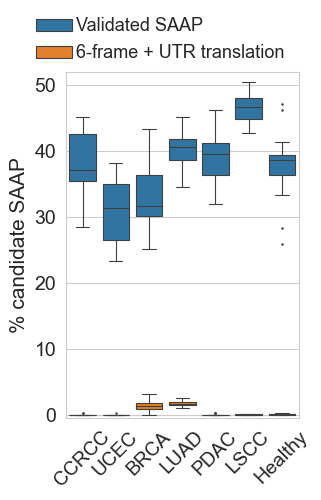

In [ ]:
# get dataframe with number of unique substituted peptides, candidate and validated
rows = []
cols = ['Dataset', 'N SAAP sequences', 'SAAP sequence type', 'TMT set']

for i,ds in enumerate(datasets):
    print(ds)
    samples = samples_list[i]
    data_dir = data_dir_list[i]
    for s in samples:
        n_seqs = get_n_unq_seqs(data_dir, s)
        n_val_seqs = get_n_unq_val(data_dir, s)
        rows.append([ds, n_seqs, 'Candidate', s])
        rows.append([ds, n_val_seqs, 'Validated', s])
plt_df = pd.DataFrame(rows, columns=cols)

# get dataframe with percentage of peptides validated and percentage of peptides with no genome homology (from filter_dict.p generated above)
pcnt_rows = []
for i,ds in enumerate(datasets):
    print(ds)
    data_dir = data_dir_list[i]
    samples = samples_list[i]
    ds_plt_df = plt_df.loc[plt_df['Dataset']==ds,:]
    ds_filter_dict = filter_dict[ds]
    for j,s in enumerate(samples):
        s_df = ds_plt_df.loc[ds_plt_df['TMT set']==s,:]
        n_cand = s_df.loc[s_df['SAAP sequence type']=='Candidate', 'N SAAP sequences'].values[0]
        n_val = s_df.loc[s_df['SAAP sequence type']=='Validated', 'N SAAP sequences'].values[0]
        val_pcnt = 100*(n_val/n_cand)
        n_aas = ds_filter_dict['AAS'][j]
        n_nonhom = ds_filter_dict['Non-homologous'][j]
        hom_pcnt = 100*(n_aas - n_nonhom)/n_aas
        pcnt_rows.append([ds,s, val_pcnt, 'Validated SAAP'])
        pcnt_rows.append([ds,s, hom_pcnt, '6-frame + UTR translation'])
pcnt_df = pd.DataFrame(pcnt_rows, columns=['Dataset', 'TMT set', '% peptides', '% type'])
nonrectum_row = [i for i,row in pcnt_df.iterrows() if (row['TMT set']!='rectum') and (row['TMT set']!='bonemarrow')] # too little data, removed these tissues from analysis
pcnt_df = pcnt_df.loc[nonrectum_row]
pcnt_df.to_excel(outdir+'percent_validated_genomehomol_SAAP.xlsx')


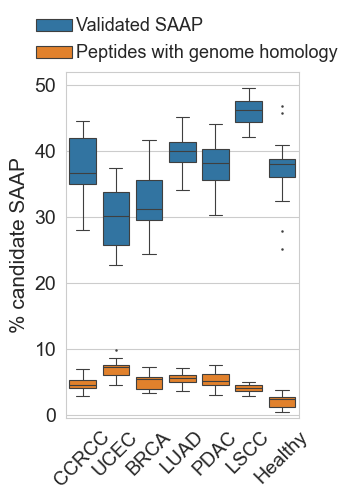

In [38]:
pcnt_df = pd.read_excel(dependencies_dir+'percent_validated_genomehomol_SAAP.xlsx', index_col=0)

# plot figure 1e
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(3,4.5))
sns.boxplot(data=pcnt_df, x='Dataset', y='% peptides', linewidth=0.8, hue='% type', fliersize=0.8, dodge=False)
plt.ylim([-0.5,52])
plt.yticks(fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('')
plt.ylabel('% candidate SAAP', fontsize=15)
plt.legend(bbox_to_anchor=(-0.2,0.98), frameon=False, loc='lower left', fontsize=13, markerscale=0.5, handletextpad=0.2)
plt.savefig(outdir+'percent_validated_genomehom_allDS_boxplot.pdf', bbox_inches='tight')



### Fig 1g. Prosit rescoring

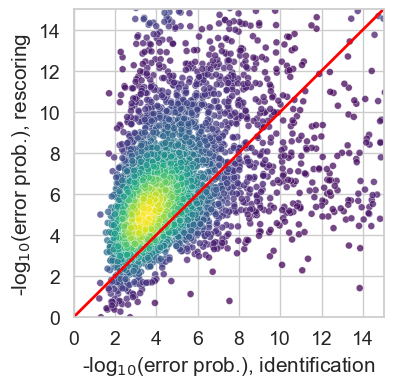

In [16]:
# read in results from prosit rescoring
rescoring_data = pd.read_csv(dependencies_dir+'Rescoring.csv')

# plot rescoring data
MTP_only = rescoring_data
sns.set(style="whitegrid")
vect1 = MTP_only['log10PEP_A'].values
vect2 = MTP_only['log10PEP_P'].values
kde = sp.stats.gaussian_kde(np.vstack([vect1, vect2]))
densities = kde(np.vstack([vect1, vect2]))

plt.figure(figsize=(4,4))
plt.xlabel('-log10(PEP) Andromeda')
plt.ylabel('-log10(PEP) Prosit')

plt.scatter(
    x=MTP_only['log10PEP_A'],
    y=MTP_only['log10PEP_P'],
    c=densities,  
    cmap='viridis', s = 25, alpha=0.75, edgecolor='w', linewidth=0.3)

plt.plot(
    [0, 15], [0, 15],  
    color='red',           
    linewidth=2 
)

plt.xlim(0, 15)
plt.ylim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks([0,2,4,6,8,10,12,14])
plt.yticks([0,2,4,6,8,10,12,14])
plt.xlabel('-log$_{10}$(error prob.), identification', fontsize=15)
plt.ylabel('-log$_{10}$(error prob.), rescoring', fontsize=15)

plt.savefig(outdir+'Prosit_Rescoring.png', dpi=300, bbox_inches='tight')

### Figure 1h. Detection of SAAP in multiple digests
Identify the same substitutions in different protease digest from the tonsil data (part of healthy tissues dataset).

##### Two new dictionaries generated here, 'Tonsil_SAAP_dict.p' and 'Tonsil_BP_dict.p' are provided in the shared google drive folder. 

If downloading, can skip the next 6 cells

In [18]:
# set directories and read in files needed to analyze the tonsil data from multiple digests

aa_subs_dir = wang_data_dir
pub_dir = wang_data_dir+'../Publication/'
enzymes = ['Trypsin', 'LysC','ArgC', 'GluC','Chymotrypsin']

# need the fasta for protein sequences - to match the substitutions across different peptides 
fasta = open(wang_data_dir+'../databases/tonsil_MTP.fasta', 'r').readlines()
fasta = [x for x in fasta if x!='\n' and len(x)>0]
fasta_headers = [x for x in fasta if x[0]=='>']
fasta_header_lines = [i for i,x in enumerate(fasta) if x[0]=='>']
fasta_seqs = [fasta[header_idx+1] for header_idx in fasta_header_lines]


mtp_quant_dict = pickle.load(open(aa_subs_dir+'tonsil_MTP_quant_dict_newvalsearch.p', 'rb'))
val_mtp_dict = pickle.load(open(aa_subs_dir+'tonsil_Ion_validated_MTP_dict_newvalsearch.p', 'rb'))
val_ev_dict = pickle.load(open(aa_subs_dir+'tonsil_Validation_search_evidence_dict.p', 'rb'))
trypsin_dict = val_mtp_dict['Trypsin']

In [19]:
def get_idx_range_of_pep_in_prot(pep_seq, prot_seq):
    """
    function to get the positions of a peptide sequence in a protein sequence
    """
    start_idx = [x.start() for x in re.finditer(pep_seq, prot_seq)][0]
    end_idx = [x.end() for x in re.finditer(pep_seq, prot_seq)][0]
    
    idx_range = list(range(start_idx,end_idx))
    return(idx_range)

def get_aa_idx_in_prot(pep_range, aa_idx):
    """
    function to get the position of an AAS in a protein, given the peptide sequence and the index of the AAS in the peptide
    """
    saap_idx = pep_range[0]+aa_idx
    return(saap_idx)

In [24]:
# create dictionaries for SAAP and BP with protein index position of the AAS annotated tonsil_saap_dict = {}

tonsil_saap_dict = {}
for s, s_dict in mtp_quant_dict.items():
    #print(s)
    saap = s_dict['MTP_seq']
    bp = s_dict['BP_seq']
    aas = s_dict['aa_sub']
    aas_idx = s_dict['sub_index'][0]
    saap_abund_dict = {k:v for k,v in s_dict['MTP_PrecInt'].items() if ~np.isnan(s_dict['Prec_ratio'][k])}
    bp_abund_dict = {k:v for k,v in s_dict['BP_PrecInt'].items() if ~np.isnan(s_dict['Prec_ratio'][k])}
    raas_dict = {k:v for k,v in s_dict['Prec_ratio'].items() if ~np.isnan(s_dict['Prec_ratio'][k])}
    digests = list(raas_dict.keys())
    
    tonsil_saap_dict[s] = {'SAAP':saap, 'BP':bp, 'AAS':aas, 'AAS_index':aas_idx, 
                           'SAAP abundance':saap_abund_dict, 'BP abundance':bp_abund_dict, 'RAAS':raas_dict,
                          'Digests':digests, 'Peptide IDs':{}}

    prots_w_saap = [i for i,seq in enumerate(fasta_seqs) if re.search(saap, seq)]
    for i,prot_idx in enumerate(prots_w_saap):
        seq = fasta_seqs[prot_idx]
        saap_idx_range = get_idx_range_of_pep_in_prot(saap, seq)
        saap_prot_idx = get_aa_idx_in_prot(saap_idx_range, aas_idx)
        tonsil_saap_dict[s]['Peptide IDs'][i] = {'saap_prot_fasta_idx':prot_idx, 'saap_prot_range':saap_idx_range, 'saap_prot_idx':saap_prot_idx}

pickle.dump(tonsil_saap_dict, open(aa_subs_dir+'Tonsil_SAAP_dict.p','wb'))


tonsil_bp_dict = {}
for s, s_dict in mtp_quant_dict.items():
    if s%100==0:
        print(s)
    bp = s_dict['BP_seq']
    rand_idx = random.sample(list(range(len(bp))), 1)[0]
    bp_abund_dict = {k:v for k,v in s_dict['BP_PrecInt'].items() if ~np.isnan(s_dict['Prec_ratio'][k])}
    digests = list(bp_abund_dict.keys())
        
    tonsil_bp_dict[s] = {'BP':bp, 'random_index':rand_idx, 'BP abundance':bp_abund_dict, 
                         'Digests':digests, 'Peptide IDs':{}}
    
    prots_w_bp = [i for i,seq in enumerate(fasta_seqs) if re.search(bp, seq)]
    
    for i,prot_idx in enumerate(prots_w_bp):
        seq = fasta_seqs[prot_idx]
        bp_idx_range = get_idx_range_of_pep_in_prot(bp, seq)
        rand_prot_idx = get_aa_idx_in_prot(bp_idx_range, rand_idx)
        
        tonsil_bp_dict[s]['Peptide IDs'][i] = {'prot_fasta_idx':prot_idx, 'bp_prot_range':bp_idx_range, 'random_prot_idx':rand_prot_idx}
pickle.dump(tonsil_bp_dict, open(aa_subs_dir+'Tonsil_BP_dict.p','wb'))

0
100
200
300
400
500
600
700
800
900
1000


#### get proteins and peptide range for all main peptides
This chunk was computationally intensive and was run on HPC for each enzyme separately and then combined. But the code is here if want to run locally. The output is also shared in the google drive. 

In [ ]:
all_enz_mainpep_prot_idx = {}

for enz in enzymes:
    print(enz)
    all_enz_mainpep_prot_idx[enz] = {}
    ev_data = val_ev_dict[enz]
    ev_data = ev_data.loc[ev_data['PEP']<=0.01]
    set_peps = list(set(ev_data['Sequence'].values))
    print(len(set_peps))

    for p,pep in enumerate(set_peps):
        if p%1000==0:
            print(p)

        all_enz_mainpep_prot_idx[enz][p] = {'Peptide':pep, 'Peptide IDs':{}}    
        prots_w_pep = [i for i,seq in enumerate(fasta_seqs) if re.search(pep, seq)]    

        for i,prot_idx in enumerate(prots_w_pep):
            seq = fasta_seqs[prot_idx]
            pep_idx_range = get_idx_range_of_pep_in_prot(pep, seq)
            rand_prot_idx = random.sample(pep_idx_range,1)

            all_enz_mainpep_prot_idx[enz][p]['Peptide IDs'][i] = {'prot_fasta_idx':prot_idx, 'pep_prot_range':pep_idx_range, 'random_prot_idx':rand_prot_idx}

pickle.dump(all_enz_mainpep_prot_idx, open(wang_data_dir+'all_tonsil_mainpeps_in_prots_newval_search.p','wb'))

Read in all_enz_mainpep_prot_idx files created above

In [29]:
all_enz_mainpep_prot_idx = pickle.load(open(wang_data_dir+'all_tonsil_mainpeps_in_prots_newval_search.p','rb'))

In [ ]:
# annotate tonsil_saap_dict and tonsil_bp_dict 
# with information about if the same substitution site (or random position for bp) is found in other digests

tonsil_same_saap_mult_dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['Digests'])>1}
for s, sdict in tonsil_saap_dict.items():
    if s%100==0:
        print(s)
    s_prot_dict = sdict['Peptide IDs']
    saap = sdict['SAAP']
    saap_idx = sdict['AAS_index'] # index of AAS in peptide

    digests = sdict['Digests']
    all_digests = copy.deepcopy(digests) 
    alt_peps = {}
    for enz in enzymes:
        if enz not in digests:
            enz_dict = all_enz_mainpep_prot_idx[enz]
            for p,prot_dict in s_prot_dict.items():
                prot_idx = prot_dict['saap_prot_fasta_idx']
                aas_idx = prot_dict['saap_prot_idx'] # index of AAS in protein
                
                main_peps = []
                for k,v in enz_dict.items():
                    pep = v['Peptide']
                    pep_ids = v['Peptide IDs']
                    for i in pep_ids:
                        pep_prot_idx = pep_ids[i]['prot_fasta_idx']
                        pep_range = pep_ids[i]['pep_prot_range']
                        if (pep_prot_idx==prot_idx) and (aas_idx in pep_range):
                            if pep[pep_range.index(aas_idx)]==saap[saap_idx]:
                                main_peps.append(k)
                                alt_peps[enz] = pep
                                break
                
                if len(main_peps)>0:
                    all_digests.append(enz)
                    break
    sdict['Same_seq_digests'] = digests
    sdict['All_digests'] = all_digests
    sdict['Alternative_peptides'] = alt_peps
pickle.dump(tonsil_saap_dict, open(aa_subs_dir+'Tonsil_SAAP_dict.p','wb'))


tonsil_same_bp_mult_dig = {k:v for k,v in tonsil_bp_dict.items() if len(v['Digests'])>1}
for s, sdict in tonsil_bp_dict.items():
    if s%100==0:
        print(s)
    s_prot_dict = sdict['Peptide IDs']
    bp = sdict['BP']
    bp_rand_idx = sdict['random_index'] # index of random position on BP
    digests = sdict['Digests']
    all_digests = copy.deepcopy(digests)

    for enz in enzymes:
        if enz not in digests:
            enz_dict = all_enz_mainpep_prot_idx[enz]

            for p,prot_dict in s_prot_dict.items():
                prot_idx = prot_dict['prot_fasta_idx']
                rand_idx = prot_dict['random_prot_idx'] # index of random position on BP in protein

                main_peps = []
                for k,v in enz_dict.items():
                    pep = v['Peptide']
                    pep_ids = v['Peptide IDs']
                    for i in pep_ids:
                        pep_prot_idx = pep_ids[i]['prot_fasta_idx']
                        pep_range = pep_ids[i]['pep_prot_range']
                        if (pep_prot_idx==prot_idx) and (rand_idx in pep_range):
                            if pep[pep_range.index(rand_idx)]==bp[bp_rand_idx]:
                                main_peps.append(k)
                                break
                if len(main_peps)>0:
                    all_digests.append(enz)
                    break
    sdict['Same_seq_digests'] = digests
    sdict['All_digests'] = all_digests
pickle.dump(tonsil_bp_dict, open(aa_subs_dir+'Tonsil_BP_dict.p','wb'))

##### Start here if downloaded Tonsil_SAAP_dict.p , Tonsil_BP_dict.p and all_tonsil_mainpeps_in_prots_newval_search.p

In [35]:
aa_subs_dir = wang_data_dir

tonsil_saap_dict= pickle.load(open(aa_subs_dir+'Tonsil_SAAP_dict.p','rb'))
tonsil_bp_dict= pickle.load(open(aa_subs_dir+'Tonsil_BP_dict.p','rb'))
all_enz_mainpep_prot_idx = pickle.load(open(aa_subs_dir+'all_tonsil_mainpeps_in_prots_newval_search.p','rb'))

In [36]:
# extract metrics for plot from tonsil_saap_dict and tonsil_bp_dict

saap_1dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==1}
saap_2dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==2}
saap_2dig_sameseq = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])==2}
saap_2dig_diffseq = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])!=2}
saap_3dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==3}
saap_4dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==4}
saap_5dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==5}
saap_gr3dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])>=3}
total = len(tonsil_saap_dict)

saap_thresh = 1e9
e9_saap_1dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==1 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e9_saap_2dig_sameseq = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])==2 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e9_saap_2dig_diffseq = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])!=2 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e9_saap_gr3dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])>=3 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e9_total = len({k:v for k,v in tonsil_saap_dict.items() if np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh})

saap_thresh = 1e8
e8_saap_1dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==1 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e8_saap_2dig_sameseq = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])==2 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e8_saap_2dig_diffseq = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])!=2 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e8_saap_gr3dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])>=3 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e8_total = len({k:v for k,v in tonsil_saap_dict.items() if np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh})

saap_thresh = 1e7
e7_saap_1dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==1 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e7_saap_2dig_sameseq = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])==2 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e7_saap_2dig_diffseq = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])!=2 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e7_saap_gr3dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])>=3 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
e7_total = len({k:v for k,v in tonsil_saap_dict.items() if np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh})

bp_1dig = {k:v for k,v in tonsil_bp_dict.items() if len(v['All_digests'])==1}
bp_2dig_sameseq = {k:v for k,v in tonsil_bp_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])==2}
bp_2dig_diffseq = {k:v for k,v in tonsil_bp_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])!=2}
bp_gr3dig = {k:v for k,v in tonsil_bp_dict.items() if len(v['All_digests'])>=3}
bp_total = len(tonsil_bp_dict)

bp_thresh = 1e9
e9_bp_1dig = {k:v for k,v in tonsil_bp_dict.items() if len(v['All_digests'])==1 and np.nanmean(list(v['BP abundance'].values()))<=bp_thresh}
e9_bp_2dig_sameseq = {k:v for k,v in tonsil_bp_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])==2 and np.nanmean(list(v['BP abundance'].values()))<=bp_thresh}
e9_bp_2dig_diffseq = {k:v for k,v in tonsil_bp_dict.items() if len(v['All_digests'])==2 and len(v['Digests'])!=2 and np.nanmean(list(v['BP abundance'].values()))<=bp_thresh}
e9_bp_gr3dig = {k:v for k,v in tonsil_bp_dict.items() if len(v['All_digests'])>=3 and np.nanmean(list(v['BP abundance'].values()))<=bp_thresh}
e9_bp_total = len({k:v for k,v in tonsil_bp_dict.items() if np.nanmean(list(v['BP abundance'].values()))<=bp_thresh})

all_saap_pcnt_1dig = 100*len(saap_1dig)/total 
all_saap_pcnt_2dig_sameseq = 100*len(saap_2dig_sameseq)/total
all_saap_pcnt_2dig_diffseq = 100*len(saap_2dig_diffseq)/total
all_saap_pcnt_3dig = 100*len(saap_gr3dig)/total

e9_saap_pcnt_1dig = 100*len(e9_saap_1dig)/e9_total 
e9_saap_pcnt_2dig_sameseq = 100*len(e9_saap_2dig_sameseq)/e9_total
e9_saap_pcnt_2dig_diffseq = 100*len(e9_saap_2dig_diffseq)/e9_total
e9_saap_pcnt_3dig = 100*len(e9_saap_gr3dig)/e9_total

e8_saap_pcnt_1dig = 100*len(e8_saap_1dig)/e8_total 
e8_saap_pcnt_2dig_sameseq = 100*len(e8_saap_2dig_sameseq)/e8_total
e8_saap_pcnt_2dig_diffseq = 100*len(e8_saap_2dig_diffseq)/e8_total
e8_saap_pcnt_3dig = 100*len(e8_saap_gr3dig)/e8_total

e7_saap_pcnt_1dig = 100*len(e7_saap_1dig)/e7_total 
e7_saap_pcnt_2dig_sameseq = 100*len(e7_saap_2dig_sameseq)/e7_total
e7_saap_pcnt_2dig_diffseq = 100*len(e7_saap_2dig_diffseq)/e7_total
e7_saap_pcnt_3dig = 100*len(e7_saap_gr3dig)/e7_total

e9_bp_pcnt_1dig = 100*len(e9_bp_1dig)/e9_bp_total 
e9_bp_pcnt_2dig_sameseq = 100*len(e9_bp_2dig_sameseq)/e9_bp_total
e9_bp_pcnt_2dig_diffseq = 100*len(e9_bp_2dig_diffseq)/e9_bp_total
e9_bp_pcnt_3dig = 100*len(e9_bp_gr3dig)/e9_bp_total

bp_pcnt_1dig = 100*len(bp_1dig)/bp_total 
bp_pcnt_2dig_sameseq = 100*len(bp_2dig_sameseq)/bp_total
bp_pcnt_2dig_diffseq = 100*len(bp_2dig_diffseq)/bp_total
bp_pcnt_3dig = 100*len(bp_gr3dig)/bp_total

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_52444/2470579539.py:17: RuntimeWarning: Mean of empty slice
  e9_saap_gr3dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])>=3 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_52444/2470579539.py:18: RuntimeWarning: Mean of empty slice
  e9_total = len({k:v for k,v in tonsil_saap_dict.items() if np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh})
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_52444/2470579539.py:24: RuntimeWarning: Mean of empty slice
  e8_saap_gr3dig = {k:v for k,v in tonsil_saap_dict.items() if len(v['All_digests'])>=3 and np.nanmean(list(v['SAAP abundance'].values()))>=saap_thresh}
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_52444/2470579539.py:25: RuntimeWarning: Mean of empty slice
  e8_total = len({k:v for k,v in tonsil_saap_dict.items() if np.nanmean(list(v['SAAP abundance'

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_52444/3503181864.py:7: SyntaxWarning: invalid escape sequence '\l'
  index=['BP', 'BP$\leq$10$^{9}$','SAAP>10$^{9}$','SAAP>10$^{8}$', 'SAAP>10$^{7}$', 'All SAAP'])


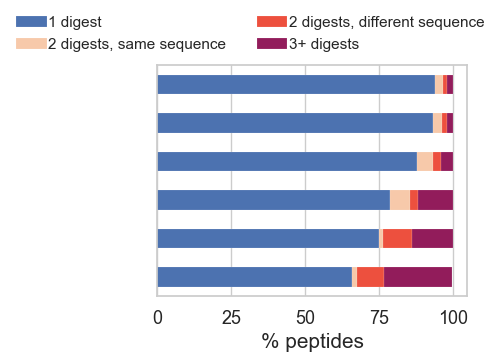

In [37]:
# create stacked barplot showing the % of SAAP in multiple digests

bar_df = pd.DataFrame({'1 digest':[bp_pcnt_1dig, e9_bp_pcnt_1dig, e9_saap_pcnt_1dig, e8_saap_pcnt_1dig, e7_saap_pcnt_1dig, all_saap_pcnt_1dig],
                     '2 digests, same sequence':[bp_pcnt_2dig_sameseq, e9_bp_pcnt_2dig_sameseq, e9_saap_pcnt_2dig_sameseq, e8_saap_pcnt_2dig_sameseq, e7_saap_pcnt_2dig_sameseq, all_saap_pcnt_2dig_sameseq],
                     '2 digests, different sequence':[bp_pcnt_2dig_diffseq, e9_bp_pcnt_2dig_diffseq, e9_saap_pcnt_2dig_diffseq, e8_saap_pcnt_2dig_diffseq, e7_saap_pcnt_2dig_diffseq, all_saap_pcnt_2dig_diffseq],
                     '3+ digests':[bp_pcnt_3dig, e9_bp_pcnt_3dig, e9_saap_pcnt_3dig, e8_saap_pcnt_3dig, e7_saap_pcnt_3dig, all_saap_pcnt_3dig]},
                      index=['BP', 'BP$\leq$10$^{9}$','SAAP>10$^{9}$','SAAP>10$^{8}$', 'SAAP>10$^{7}$', 'All SAAP'])

saap_bar_df = bar_df.loc[[i for i in bar_df.index if 'SAAP' in i]]
bp_bar_df = bar_df.loc[[i for i in bar_df.index if 'BP' in i]]

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(4,6), sharex=True)
palette = sns.color_palette('rocket_r', n_colors=10)
palette = [colors[0], palette[0], palette[3], palette[6], palette[9]]

bar_df.plot(kind='barh',stacked=True, figsize=(4,3), color=palette, linewidth=0.1, ax=ax)
ax.set_yticks([])
ax.legend().remove()
ax.set_xlabel('% peptides', fontsize=15)
ax.tick_params('x', labelsize=13)
plt.legend(bbox_to_anchor=(-0.5,1), ncol=2, frameon=False, loc='lower left', handletextpad=0.1, fontsize=11)

plt.savefig(outdir+'BP_SAAP_%multdigests_bar_binnedSAAP_horz_newvalsearch_bpthresh.pdf', bbox_inches='tight')

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_52444/2061950844.py:8: RuntimeWarning: divide by zero encountered in log10
  bp_abund = np.log10(np.mean(list(sdict['BP abundance'].values())))
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_52444/2061950844.py:7: RuntimeWarning: divide by zero encountered in log10
  saap_abund = np.log10(np.mean(list(sdict['SAAP abundance'].values())))
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/lib/python3.12/s

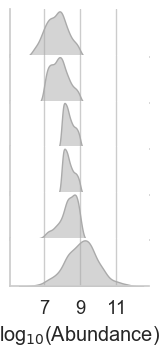

In [38]:
# create ridgeplot with the abundance distributions of the peptides in each bar of the barplot 

ridge_rows = []
ridge_cols = ['log$_{10}$(Abundance)','Group']

for s,sdict in tonsil_saap_dict.items():
    saap_abund = np.log10(np.mean(list(sdict['SAAP abundance'].values())))
    bp_abund = np.log10(np.mean(list(sdict['BP abundance'].values())))
    
    if saap_abund!=0 and bp_abund!=0:
        if saap_abund<=7:
            ridge_rows.append([saap_abund, 'All SAAP'])
        elif saap_abund<=8:
            ridge_rows.append([saap_abund, 'All SAAP'])
            ridge_rows.append([saap_abund, 'Log$_{10}$SAAP>7'])
        elif saap_abund<=9:
            ridge_rows.append([saap_abund, 'All SAAP'])
            ridge_rows.append([saap_abund, 'Log$_{10}$SAAP>7'])
            ridge_rows.append([saap_abund, 'Log$_{10}$SAAP>8'])
            ridge_rows.append([saap_abund, 'Log$_{10}$SAAP>9'])
        ridge_rows.append([bp_abund, 'BP'])
        if bp_abund<=9:
            ridge_rows.append([bp_abund, 'Log$_{10}$BP<9'])

ridge_df = pd.DataFrame(ridge_rows, columns=ridge_cols)
ridge_df.replace(-np.inf, np.nan, inplace=True)
ridge_df.replace(np.inf, np.nan, inplace=True)
ridge_df.dropna(how='any', axis=0, inplace=True)

bp_ridge_df = ridge_df.loc[ridge_df['Group']=='BP']
saap_ridge_df = ridge_df.loc[ridge_df['Group']!='BP']

sns.set(font_scale=1.2)
sns.set_style('whitegrid')
g = sns.FacetGrid(ridge_df, row='Group', aspect=3, height=0.6, sharex=True,sharey=False, gridspec_kws={'hspace':-0.05},
                 row_order=['All SAAP', 'Log$_{10}$SAAP>7', 'Log$_{10}$SAAP>8', 'Log$_{10}$SAAP>9', 'Log$_{10}$BP<9', 'BP'])
g.set_titles("")
g.set(yticks=[])
g.set(xticks=[7,9,11])
g.map_dataframe(sns.kdeplot, x='log$_{10}$(Abundance)', fill=True, color='#AAAAAA', alpha=0.5)
g.savefig(outdir+'BP_SAAP_abund_ridgeplot_nevalsearch.pdf', bbox_inches='tight')

### Extended Data Figure 1i. PEP post-FDR correction

/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_52444/107954290.py:15: RuntimeWarning: divide by zero encountered in log10
  plot_df['-log q'] = plot_df.apply(lambda x: -np.log10(x['q-value']),axis=1)
/var/folders/jh/xlgb4y497ms2xscmydjlsrb40000gp/T/ipykernel_52444/107954290.py:16: RuntimeWarning: divide by zero encountered in log10
  plot_df['-log PEP'] = plot_df.apply(lambda x: -np.log10(x['PEP']),axis=1)


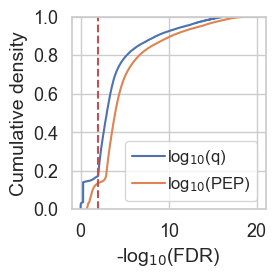

In [39]:
# plot the p-values determined by MaxQuant and the q-values determined from only the substituted peptides

plot_rows = []
plot_cols = ['Dataset', 'TMT/Tissue', 'q-value', 'PEP']
for ds in datasets:
    data_dir = data_dir_list[datasets.index(ds)]
    samples = samples_list[datasets.index(ds)]
    qmtp_dict = pickle.load(open(data_dir+'qMTP_dict.p', 'rb'))
    for s in samples:
        s_dict = qmtp_dict[s]
        for k,v in s_dict['Posterior subs probability'].items():
            plot_rows.append([ds, s, 1-v[0], s_dict['q-value'][k][0]])
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

plot_df['-log q'] = plot_df.apply(lambda x: -np.log10(x['q-value']),axis=1)
plot_df['-log PEP'] = plot_df.apply(lambda x: -np.log10(x['PEP']),axis=1)

fig,ax = plt.subplots(figsize=(2.5,2.5))
sns.ecdfplot(plot_df, x='-log q', label='log$_{10}$(q)')
sns.ecdfplot(plot_df, x='-log PEP', label='log$_{10}$(PEP)')
plt.ylabel('Cumulative density', fontsize=14)
plt.xlabel('-log$_{10}$(FDR)', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.plot((2,2), plt.ylim(), '--r')
plt.legend(loc='lower right', fontsize=12, handletextpad=0.1)
plt.savefig(outdir+'qvalue_CumDensity_plot.pdf', bbox_inches='tight')

### Extended Data Figure 1 c,d. Trancript coverage stats

""" Can be used to regenerate the RNA sequence coverage data from the custom database generation pipeline output
Takes a while. Recommended to just read in seq_cov_frac.p in next cell to generate figures. 
"""

In [ ]:
# functions to get transcriptome sequence coverage by RNA-seq for the samples in the datasets analyzed. Read in results below. 

def find_all_matches(file_path, regex_pattern):
    """Finds all instances of a regular expression in a text file.

    Args:
    file_path: Path to the text file.
    regex_pattern: The regular expression pattern to search for.

    Returns:
    A list of all matching strings.
    """

    matches = []
    with open(file_path, 'r') as file:
        for line in file:
            for match in re.finditer(regex_pattern, line):
                matches.append(match.group())
    return(matches)


def get_transcrip_coverage(tmap_path):
    """
    Returns the fraction of a transcriptome with a sequencing read.
    Input is the path to a .gft.tmap file, generated by the custom protein database pipeline
    Output is the a list of the fraction covered of each sequence in the file provided
    
    """
    
    lines = zip_ref.open(tmap_path, 'r').readlines()
    lines = [line.decode('utf-8') for line in lines]
    lines = [x.split('\n')[0] for x in lines]
    cols = [x for x in lines[0].split('\t') if len(x)>0]
    mtx = [x.split('\t') for x in lines[1:]]
    df = pd.DataFrame(mtx, columns=cols)
    t_len = df['len'].astype(int).to_list()
    match_len = df['ref_match_len'].to_list()
    match_len = [int(x) if x!='-' else 0 for x in match_len]
    frac_cov = [match_len[i]/t_len[i] for i in range(len(match_len))]
    frac_cov = [x for x in frac_cov if x<=1]
    return(frac_cov)


# get a dictionary with each sample in each dataset and a list of the transcript sequence covereage in each samples database
seq_cov_frac = {ds:{} for ds in datasets}
for ds in datasets:
    print(ds)
    ds_dir = proj_dir_list[datasets.index(ds)]
    rnaseq_dir = ds_dir+'RNAseq_data/'
    zip_files = glob(rnaseq_dir+'*files2transfer.zip')

    print(len(zip_files))
    for i,zipdir in enumerate(zip_files):
        sample = zipdir.split('/')[-1].split('.')[0]
        file2read = 'files2transfer/'+sample+'.gffcmp.'+sample+'.stringtie.gtf.tmap'
        try:
            with zipfile.ZipFile(zipdir, 'r') as zip_ref:
                try:
                    frac_cov = get_transcrip_coverage(file2read)
                    seq_cov_frac[ds][sample] = frac_cov
                except:
                    print('file not found')
        except:
            print('notzipfile')

In [41]:
seq_cov_frac = pickle.load(open(dependencies_dir+'seq_cov_frac.p', 'rb'))

In [ ]:
# extract and plot overall distribution of the transcript sequence coverage per sample         
frac_cov = [list(seq_cov_frac[ds].values()) for ds in datasets]
frac_cov = [x for y in frac_cov for x in y]
frac_cov = [x for y in frac_cov for x in y]
frac_cov = [100*x for x in frac_cov]

n_samples = np.sum([len(seq_cov_frac[ds].keys()) for ds in datasets])
weights=[1/n_samples]*len(frac_cov)
plot_df = pd.DataFrame(zip(frac_cov, weights), columns=['Transcript coverage', 'Weight'])

/opt/anaconda3/lib/python3.12/site-packages/seaborn/distributions.py:413: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


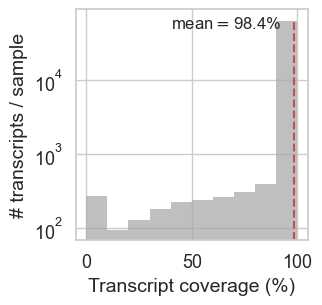

In [45]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))
sns.histplot(data=plot_df, x='Transcript coverage', weights='Weight', color='#AAAAAA', linewidth=0, )
mean = np.mean(frac_cov)
plt.plot((mean, mean), ax.get_ylim(), '--r')
ax.annotate('mean$=$'+str(np.round(mean,1))+'%', xy=(40,5e4), fontsize=12)
plt.xlabel('Transcript coverage (%)', fontsize=14)
plt.ylabel('# transcripts / sample', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.yscale('log')
plt.savefig(outdir+'transcript_coverage_percent_persample_all_hist.png', dpi=300, bbox_inches='tight')

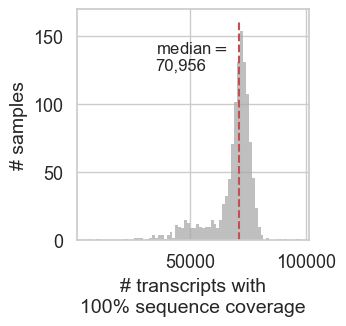

In [43]:
# extract and plot a distribution of the number of transcripts with 100% sequence coverage

plot_rows = []
plot_cols = ['Sample', 'N transcripts 100%']
for ds in datasets:
    ds_dict = seq_cov_frac[ds]
    for k,v in ds_dict.items():
        plot_rows.append([k, len([x for x in v if x==1])])
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
plot_df  = plot_df.loc[plot_df['N transcripts 100%']!=0]

fig,ax = plt.subplots(figsize=(3,3))
sns.histplot(data=plot_df, x='N transcripts 100%', color='#AAAAAA', linewidth=0, )
median = np.median(plot_df['N transcripts 100%'].to_list())
plt.plot((median, median), ax.get_ylim(), '--r')
ax.annotate('median$=$\n70,956', xy=(35000,125), fontsize=12)
plt.xlabel('# transcripts with\n100% sequence coverage', fontsize=14)
plt.ylabel('# samples', fontsize=14)
ax.tick_params('both', labelsize=13)

plt.savefig(outdir+'n_transctipts_100pcnt_coverage_all_hist.png', dpi=300, bbox_inches='tight')

### Extended Data Figure 1j: K/R AAS

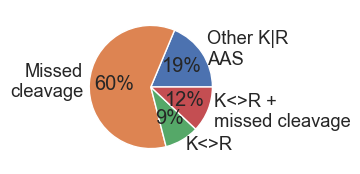

In [46]:
# the file used here is the same as Supplemental_Data_2.SAAP_protein.xlsx but include SAAP with substitutions of K or R which were then filtered out and only has a subset of the columns (no protein data) 
all_saap_protein_df = pd.read_excel(dependencies_dir+'All_SAAP_protein_filter_df_w_KR_AAS.xlsx')

# get index of SAAP-BP pairs with substitution of K or R
all_aas = all_saap_protein_df['AAS'].values
kr_idx = [i for i,aas in enumerate(all_aas) if 'K' in aas or 'R' in aas]

# subset of K|R substitutions that are K->R or R->K
k2r_aas = [i for i in kr_idx if 'K' in all_aas[i] and 'R' in all_aas[i]]

# subset of K|R substitutions that are missed cleavages
all_kr_saaps = all_saap_protein_df.loc[kr_idx, 'SAAP'].values
all_kr_saaps_trimmed = [x[:-1] for x in all_kr_saaps]
all_missed_cleavages = [x for x in all_kr_saaps_trimmed if 'K' in x or 'R' in x]
missed_cleavage_idx = [i for i in kr_idx if 'R' in  all_saap_protein_df.loc[i,'SAAP'][:-1] or 'K' in  all_saap_protein_df.loc[i,'SAAP'][:-1]]

# subsets of K|R substitutions for pie chart
other_kr_idx = [i for i in kr_idx if i not in k2r_aas and i not in missed_cleavage_idx]
k2r_aas_and_missed = [i for i in k2r_aas if i in missed_cleavage_idx]
miss_cleavage_only = [i for i in missed_cleavage_idx if i not in k2r_aas]
k2r_aas_only = [i for i in k2r_aas if i not in missed_cleavage_idx]

# plot pie chart
labels = 'Other K|R\nAAS', 'Missed\ncleavage', 'K<>R', 'K<>R +\nmissed cleavage'
sizes = [len(other_kr_idx), len(miss_cleavage_only), len(k2r_aas_only), len(k2r_aas_and_missed)]
fig,ax=plt.subplots(figsize=(2,2))
ax.pie(sizes, labels=labels, labeldistance=1.1, autopct='%1.f%%')
plt.savefig(outdir+'KR_missed_clevage_pie.pdf', bbox_inches='tight')

### Extended Data Figure 1h and Supplemental Figures 1,2,4

The following steps can be replicated using the code below. Output files are also provided in the decode output, so if downloaded, figures can be generated without rerunning the code. 

1. Positional probabilities and fragments used for peptide ID were extracted from MQ data and pipeline output dictionaries for each SAAP. 
2. Fragment ion spectra for SAAP with high RAAS (>0.1) and high positional probability (>0.9), and their corresponding BP, were predicted with Prosit. 
3. Mirror plots were generated comparing predicted vs. observed spectra.
4. Spectral similarity scores between observed and theoretical SAAP and alternative hypothesis spectra



In [11]:
# amino acid molecular weight dictionary
MW_dict = {"G": 57.02147,
            "A" : 71.03712,
            "S" : 87.03203,
            "P" : 97.05277,
            "V" : 99.06842,
            "T" : 101.04768,
            "I" : 113.08407,
            "L" : 113.08407,
            "N" : 114.04293,
            "D" : 115.02695,
            "Q" : 128.05858,
            #"K" : 128.09497,
            "K" : 357.257902, # mass of lysine is adjusted to reflect TMT label
            "E" : 129.0426,
            "M" : 131.04049,
            "H" : 137.05891,
            "F" : 147.06842,
            "R" : 156.10112,
            "C" : 160.030654,
            "Y" : 163.0633,
            "W" : 186.07932,
            }

# mass of y ions = sum of residue masses + 19
# mass of b ions = sum of residue masses + 1

# function to get the sequence of the fragment given the precursor sequence and the fragment type
def get_frag_seq(fragment, sequence):
    frag_len = int(fragment[1:])
    if 'y' in fragment:
        frag_seq = sequence[-frag_len:]
    else:
        frag_seq = sequence[:frag_len]
    return(frag_seq)

In [ ]:
""" get dataframe with positional probabilities and fragment ion information for all datasets """
# can skip this if just reading in output files 

pos_prob_dfs = []
frag_dict = {}

count=0 
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    ds_proj_dir = proj_dir_list[datasets.index(ds)]
    mq_dir = ds_proj_dir+'MQ_output/Validation_search'
    samples = samples_list[datasets.index(ds)]
    mtp_dict = pickle.load(open(data_dir+'Ion_validated_MTP_dict.p', 'rb'))

    for s in samples:
        print(s)
        s_df = pd.DataFrame.from_dict(mtp_dict[s])
        s_df = s_df.loc[:, ['mistranslated sequence', 'DP Base Sequence', 'aa subs', 'origin aa index', 'aa subs positional probability', 'Charge']]
        s_df['TMT set'] = [s]*len(s_df)
        s_df['Dataset'] = [ds]*len(s_df)
        s_df.reset_index(inplace=True, drop=True)

        frag_dict = {i:{'SAAP':{}, 'BP':{}} for i,row in s_df.iterrows()}
        s_df['saap_b_left_frag'] = ['']*len(s_df)
        s_df['saap_b_left_frag_mass'] = [np.nan]*len(s_df)
        s_df['saap_b_right_frag'] = ['']*len(s_df)
        s_df['saap_b_right_frag_mass'] = [np.nan]*len(s_df)
        s_df['saap_y_left_frag'] = ['']*len(s_df)
        s_df['saap_y_left_frag_mass'] = [np.nan]*len(s_df)
        s_df['saap_y_right_frag'] = ['']*len(s_df)
        s_df['saap_y_right_frag_mass'] = [np.nan]*len(s_df)

        s_df['bp_b_left_frag'] = ['']*len(s_df)
        s_df['bp_b_left_frag_mass'] = [np.nan]*len(s_df)
        s_df['bp_b_right_frag'] = ['']*len(s_df)
        s_df['bp_b_right_frag_mass'] = [np.nan]*len(s_df)
        s_df['bp_y_left_frag'] = ['']*len(s_df)
        s_df['bp_y_left_frag_mass'] = [np.nan]*len(s_df)
        s_df['bp_y_right_frag'] = ['']*len(s_df)
        s_df['bp_y_right_frag_mass'] = [np.nan]*len(s_df)
        
        open_msms = False
        try:
            msms_df = pd.read_csv(mq_dir+'/'+s+'/txt/msms.txt', sep='\t')
            open_msms = True
        except:
            pass
        
        if open_msms:
            for i,row in s_df.iterrows():
                saap = row['mistranslated sequence']
                bp = row['DP Base Sequence']
                idx = row['origin aa index']
                frag_dict[i+count] = {}
                

                saap_df = msms_df.loc[msms_df['Sequence']==saap, ['Sequence', 'Matches', 'Mass deviations [Da]', 'Masses', 'Number of matches']]
                saap_df.sort_values('Number of matches', inplace=True, ascending=False)
                if len(saap_df)>0:
                    saap_df = saap_df.iloc[0]
                    saap_matches = saap_df['Matches'].split(';')
                    saap_masses = saap_df['Masses'].split(';')
                    
                    saap_frag_dict = {saap_matches[i]:saap_masses[i] for i in range(len(saap_matches)) if ('b' in saap_matches[i] or 'y' in saap_matches[i]) and '-' not in saap_matches[i]} 
                    frag_dict[i+count]['SAAP'] = saap_frag_dict
                    saap_b_left = 'b'+str(idx)
                    saap_b_right = 'b'+str(idx+1)
                    saap_y_left = 'y'+str(len(saap)-idx+1)
                    saap_y_right = 'y'+str(len(saap)-idx)
                    s_df.loc[i,'saap_b_left_frag'] = saap_b_left
                    s_df.loc[i,'saap_b_right_frag'] = saap_b_right
                    s_df.loc[i,'saap_y_left_frag'] = saap_y_left
                    s_df.loc[i,'saap_y_right_frag'] = saap_y_right
                    if saap_b_left in saap_frag_dict:
                        s_df.loc[i,'saap_b_left_frag_mass'] = saap_frag_dict[saap_b_left]
                    if saap_b_right in saap_frag_dict:
                        s_df.loc[i,'saap_b_right_frag_mass'] = saap_frag_dict[saap_b_right]
                    if saap_y_left in saap_frag_dict:
                        s_df.loc[i,'saap_y_left_frag_mass'] = saap_frag_dict[saap_y_left]
                    if saap_y_right in saap_frag_dict:
                        s_df.loc[i,'saap_y_right_frag_mass'] = saap_frag_dict[saap_y_right]

                
                bp_df = msms_df.loc[msms_df['Sequence']==bp, ['Sequence', 'Matches', 'Mass deviations [Da]', 'Masses', 'Number of matches']]
                bp_df.sort_values('Number of matches', inplace=True, ascending=False)
                if len(bp_df)>0:
                    bp_df = bp_df.iloc[0]
                    bp_matches = bp_df['Matches'].split(';')
                    bp_masses = bp_df['Masses'].split(';')

                    bp_frag_dict = {bp_matches[i]:bp_masses[i] for i in range(len(bp_matches)) if ('b' in bp_matches[i] or 'y' in bp_matches[i]) and '-' not in bp_matches[i]} 
                    frag_dict[i+count]['BP'] = bp_frag_dict
                    bp_b_left = 'b'+str(idx)
                    bp_b_right = 'b'+str(idx+1)
                    bp_y_left = 'y'+str(len(bp)-idx+1)
                    bp_y_right = 'y'+str(len(bp)-idx)
                    s_df.loc[i,'bp_b_left_frag'] = bp_b_left
                    s_df.loc[i,'bp_b_right_frag'] = bp_b_right
                    s_df.loc[i,'bp_y_left_frag'] = bp_y_left
                    s_df.loc[i,'bp_y_right_frag'] = bp_y_right

                    if bp_b_left in bp_frag_dict:
                        s_df.loc[i,'bp_b_left_frag_mass'] = bp_frag_dict[bp_b_left]
                    if bp_b_right in bp_frag_dict:
                        s_df.loc[i,'bp_b_right_frag_mass'] = bp_frag_dict[bp_b_right]
                    if bp_y_left in bp_frag_dict:
                        s_df.loc[i,'bp_y_left_frag_mass'] = bp_frag_dict[bp_y_left]
                    if bp_y_right in bp_frag_dict:
                        s_df.loc[i,'bp_y_right_frag_mass'] = bp_frag_dict[bp_y_right]


        pos_prob_dfs.append(s_df)
        count+=len(s_df)
        
pos_prob_df = pd.concat(pos_prob_dfs)
pos_prob_df.columns = ['SAAP', 'BP', 'AAS', 'AAS index', 'Positional probability', 'charge', 'TMT set', 'Dataset', 'saap_b_left_frag', 'saap_b_left_frag_mass', 'saap_b_right_frag', 'saap_b_right_frag_mass', 'saap_y_left_frag', 'saap_y_left_frag_mass', 'saap_y_right_frag', 'saap_y_right_frag_mass', 'bp_b_left_frag', 'bp_b_left_frag_mass', 'bp_b_right_frag', 'bp_b_right_frag_mass', 'bp_y_left_frag', 'bp_y_left_frag_mass', 'bp_y_right_frag', 'bp_y_right_frag_mass']

pos_prob_df.to_csv(outdir+'Position_probability_fragment_ion_data.csv')
pickle.dump(frag_dict, open(outdir+'Fragment_ion_dict.p', 'wb')) ### keys of frag_dict refer to the index in pos_prob_df

In [47]:
""" Read in the data generated in the cell above from decode output"""

pos_prob_df = pd.read_csv(dependencies_dir+'Position_probability_fragment_ion_data.csv', index_col=0)
frag_dict = pickle.load(open(dependencies_dir+'Fragment_ion_dict.p', 'rb')) ### keys of frag_dict refer to the index in pos_prob_df

### Supplemental Data Figure 4a : positional probability distribution

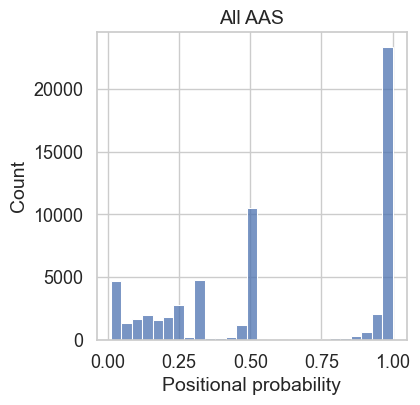

In [48]:
fig,ax = plt.subplots(figsize=(4,4))

sns.histplot(data=pos_prob_df, x='Positional probability')#, hue='Hue', kde=True, fill=False, stat='percent')#, hue_norm=True)
#plt.yscale('log')
ax.tick_params('both', labelsize=13)
plt.xlabel('Positional probability', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('All AAS', fontsize=14)
plt.savefig(outdir+'loc_prob_all_AAS.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(outdir+'loc_prob_all_AAS.pdf', bbox_inches='tight')

In [ ]:
""" predict fragment ion spectra for SAAP and BP with high RAAS and high positional probability """
# could also read in predictions from decode output 

from koinapy import Koina

# dictionary with HCD collision energies used for each dataset (from respective publications)
ce_dict = {'CCRCC':37, 'UCEC':30, 'LUAD':31, 'PDAC':37, 'LSCC':31, 'BRCA':38, 'Healthy':25}


prec_quant = pd.read_excel(proj_dir+'Supplemental_Data_3.SAAP_precursor_quant.xlsx', index_col=0)
high_raas_loc_prec_quant = prec_quant.loc[(prec_quant['RAAS']>=-1) & (prec_quant['Positional probability']>=0.9)]


# get pos_prob rows corresponding to highRaas high conf rows
highconf_vals = high_raas_loc_prec_quant.values
keeprows = []
for r,row in pos_prob_df.iterrows():
    saap = row['SAAP']
    bp = row['BP']
    tmt = row['TMT set']
    ds = row['Dataset']

    highconf_row = [i for i in range(len(highconf_vals)) if highconf_vals[i][1]==saap and highconf_vals[i][2]==bp and highconf_vals[i][0]==ds and highconf_vals[i][4]==tmt]
    if len(highconf_row)>0:
        keeprows.append(r)
highconf_pos_prob = pos_prob.loc[keeprows]

# get dataframes for each dataset with SAAP sequences for prediction and another with BP sequences for prediction
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    ds_df = highconf_pos_prob.loc[highconf_pos_prob['Dataset']==ds]
    ds_df = ds_df.loc[:, ['SAAP', 'charge']]
    ds_df.columns=['peptide_sequences', 'precursor_charges']
    ds_df['collision_energies'] = [ce_dict[ds]]*len(ds_df)
    ds_df['fragmentation_types'] = ['HCD']*len(ds_df)
    if ds!='Healthy':
        ds_df['peptide_sequences'] = ['[UNIMOD:737]-'+seq for seq in ds_df['peptide_sequences'].to_list()]
       #mt_dfs.append(ds_df)
    ds_df.to_csv(data_dir'SAAP_data4prediction.csv')
    
    
    ds_df = ds_df.loc[:, ['BP', 'charge']]
    ds_df.columns=['peptide_sequences', 'precursor_charges']
    ds_df['collision_energies'] = [ce_dict[ds]]*len(ds_df)
    ds_df['fragmentation_types'] = ['HCD']*len(ds_df)
    if ds!='Healthy':
        ds_df['peptide_sequences'] = ['[UNIMOD:737]-'+seq for seq in ds_df['peptide_sequences'].to_list()]
        #tmt_dfs.append(ds_df)
    ds_df.to_csv(data_dir'BP_data4prediction.csv')

    
# predict fragment ion spectra
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    inputs = pd.read_csv(outdir+ds+'_SAAP_data4prediction.csv', index_col=0)
    if ds!='Healthy':
        model = Koina("Prosit_2020_intensity_TMT", "koina.wilhelmlab.org:443")
    else:
        model = Koina("Prosit_2020_intensity_HCD", "koina.wilhelmlab.org:443")
    pred_list = []
    
    for i,row in inputs.iterrows():
        row_df = pd.DataFrame(row).transpose()
        try:
            pred = model.predict(row_df)
            pred_list.append(pred)
        except:
            pass
    
    pred_df = pd.concat(pred_list)
    pred_df.to_csv(data_dir+ds+'_SAAP_predictions.csv')
    
    inputs = pd.read_csv(outdir+ds+'_BP_data4prediction.csv', index_col=0)
    if ds!='Healthy':
        model = Koina("Prosit_2020_intensity_TMT", "koina.wilhelmlab.org:443")
    else:
        model = Koina("Prosit_2020_intensity_HCD", "koina.wilhelmlab.org:443")
    pred_list = []
    
    for i,row in inputs.iterrows():
        row_df = pd.DataFrame(row).transpose()
        try:
            pred = model.predict(row_df)
            pred_list.append(pred)
        except:
            pass
    
    pred_df = pd.concat(pred_list)
    pred_df.to_csv(data_dir+ds+'_BP_predictions.csv')

In [ ]:
### Supplemental Data Figure 4b : Spectral cosine similarity of observed spectra against theoretical SAAP and alternative hypothesis spectra
from matchms import Spectrum
from matchms.similarity import CosineGreedy
from matchms.similarity import CosineHungarian
from matchms.similarity import ModifiedCosine


In [10]:
pos_prob = pd.read_csv(dependencies_dir+'Position_probability_fragment_ion_data.csv', index_col=0)
frag_ion_dict = pickle.load(open(dependencies_dir+'Fragment_ion_dict.p','rb'))
#high_raas_loc_prec_quant = pd.read_excel(outdir+'High_RAAS_high_conf_prec_quant.xlsx', index_col=0)
qg_pos_prob = pos_prob.loc[pos_prob['AAS']=='Q to G']
qg_pos_prob = qg_pos_prob.loc[[i for i,row in qg_pos_prob.iterrows() if re.match('AG', row['SAAP'])]]
qg_frag_dict = {i:x for i,x in frag_ion_dict.items() if i in qg_pos_prob.index}

In [ ]:
qg_score_rows = []
qg_score_cols = ['Dataset', 'SAAP', 'Alt SAAP', 'SAAP fragments', 'SAAP m/z', 'SAAP intensity pcnt', 'Predicted fragments', 'Predicted m/z', 'Predicted intensity percent', 'Score', 'N matches', 'Alt predicted fragments', 'Alt predicted m/z', 'Alt predicted intensity percent', 'Alt score', 'Alt N matches']
cam_mod = 57.02

for ds in datasets:
    print(ds)
    
    ds_qg_pos_prob = qg_pos_prob.loc[qg_pos_prob['Dataset']==ds]
    print(len(ds_qg_pos_prob))

    # read in prosit predictions
    predictions = pd.read_csv(dependencies_dir+ds+'_Prosit_predictions.csv', index_col=0)
    predictions['SAAP'] = [x[13:] for x in predictions['peptide_sequences']]
    predictions['fragment'] = [x[2:].split('+')[0] for x in predictions['annotation']]
    predictions = predictions.loc[[i for i,row in predictions.iterrows() if '+1' in row['annotation']]]
    
    for i, row in ds_qg_pos_prob.iterrows():
        row = ds_qg_pos_prob.loc[i]
        saap = row['SAAP']
        #c_idx = [j for j,x in enumerate(saap) if x=='C']
        #frags_w_c = []
        #for c in c_idx:
        #    frags_w_c += ['b'+str(j) for j in list(range(len(saap))) if j>=c+1] + ['y'+str(len(saap)-j) for j in list(range(len(saap))) if j<c+1]

        saap_frags = qg_frag_dict[i]['SAAP']
        meas_int_total = np.sum([int(saap_frags[f]['Intensity']) for f in saap_frags.keys()])
        for k,v in saap_frags.items():
            v['Intensity_percent'] = 100*int(v['Intensity'])/meas_int_total

        saap_pred = predictions.loc[predictions['SAAP']==saap]
        alt_saap = 'Q'+saap[2:]
        alt_saap_pred = predictions.loc[predictions['SAAP']==alt_saap]
        #alt_c_idx = [j for j,x in enumerate(alt_saap) if x=='C']
        #alt_frags_w_c = []
        #for c in alt_c_idx:
        #    alt_frags_w_c += ['b'+str(j) for j in list(range(len(alt_saap))) if j>=c+1] + ['y'+str(len(alt_saap)-j) for j in list(range(len(saap))) if j<c+1]
            
        if len(saap_pred)>0 and len(alt_saap_pred)>0:
            saap_pred = saap_pred.loc[saap_pred.index.to_list()[0]]
            pred_int_total = saap_pred['intensities'].sum()
            pred_int_pcnt = [100*x/pred_int_total for x in saap_pred['intensities']]
            saap_pred['intensities_percent'] = pred_int_pcnt

            alt_saap_pred = alt_saap_pred.loc[alt_saap_pred.index.to_list()[0]]
            alt_pred_int_total = alt_saap_pred['intensities'].sum()
            alt_pred_int_pcnt = [100*x/alt_pred_int_total for x in alt_saap_pred['intensities']]
            alt_saap_pred['intensities_percent'] = alt_pred_int_pcnt

            meas_frags = list(saap_frags.keys())
            meas_mz = [float(saap_frags[f]['Mass']) for f in saap_frags.keys()]
            meas_int = [float(saap_frags[f]['Intensity_percent']) for f in saap_frags.keys()]
            meas_sorted_idx = np.argsort(meas_mz)
            meas_frags = [meas_frags[i] for i in meas_sorted_idx]
            meas_mz = np.array([meas_mz[i] for i in meas_sorted_idx])
            meas_int = np.array([meas_int[i] for i in meas_sorted_idx])

            pred_frags = saap_pred['fragment'].values
            pred_mz = saap_pred['mz'].values
            pred_int = saap_pred['intensities_percent'].values
            pred_sorted_idx = np.argsort(pred_mz)
            pred_frags = [pred_frags[i] for i in pred_sorted_idx]
            pred_mz = np.array([pred_mz[i] for i in pred_sorted_idx])
            pred_int = np.array([pred_int[i] for i in pred_sorted_idx])
            #for j,frag in enumerate(pred_frags):
            #    if j in frags_w_c:
            #        pred_mz[j]=pred_mz[j]+cam_mod

            alt_pred_frags = alt_saap_pred['fragment'].values
            alt_pred_mz = alt_saap_pred['mz'].values
            alt_pred_int = alt_saap_pred['intensities_percent'].values
            alt_pred_sorted_idx = np.argsort(alt_pred_mz)
            alt_pred_frags = [alt_pred_frags[i] for i in alt_pred_sorted_idx]
            alt_pred_mz = np.array([alt_pred_mz[i] for i in alt_pred_sorted_idx])
            alt_pred_int = np.array([alt_pred_int[i] for i in alt_pred_sorted_idx])
            #for j,frag in enumerate(alt_pred_frags):
            #    if j in alt_frags_w_c:
            #       alt_pred_mz[j]=alt_pred_mz[j]+cam_mod

            ref = Spectrum(mz=meas_mz, intensities=meas_int)
            query = Spectrum(mz=pred_mz, intensities=pred_int)
            alt_query = Spectrum(mz=alt_pred_mz, intensities=alt_pred_int)

            cosine_greedy = CosineHungarian(tolerance=0.2)
            score_arr = cosine_greedy.pair(ref, query)
            score = score_arr['score']
            matches = score_arr['matches']

            alt_cosine_greedy = CosineHungarian(tolerance=0.2)
            alt_score_arr = cosine_greedy.pair(ref, alt_query)
            alt_score = alt_score_arr['score']
            alt_matches = alt_score_arr['matches']

            meas_frags = ';'.join(meas_frags)
            meas_mz = ';'.join([str(x) for x in meas_mz])
            meas_int = ';'.join([str(x) for x in meas_int])
            pred_frags = ';'.join(pred_frags)
            pred_mz = ';'.join([str(x) for x in pred_mz])
            pred_int = ';'.join([str(x) for x in pred_int])
            alt_pred_frags = ';'.join(alt_pred_frags)
            alt_pred_mz = ';'.join([str(x) for x in alt_pred_mz])
            alt_pred_int = ';'.join([str(x) for x in alt_pred_int])
            qg_score_rows.append([ds, saap, alt_saap, meas_frags, meas_mz, meas_int, pred_frags, pred_mz, pred_int, score, matches, alt_pred_frags, alt_pred_mz, alt_pred_int, alt_score, alt_matches])
    print(len(qg_score_rows))
qg_score_df = pd.DataFrame(qg_score_rows, columns=qg_score_cols)
qg_score_df['Score difference'] = [row['Score']-row['Alt score'] for i,row in qg_score_df.iterrows()]

qg_score_df.sort_values('Score difference', ascending=False, inplace=True)
qg_score_df.to_csv(outdir+'QtoG_prediction_cosinesimilarity_data.csv')


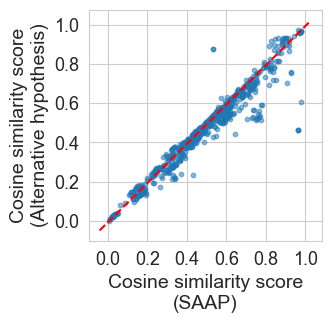

In [7]:
qg_score_df = pd.read_csv(dependencies_dir+'QtoG_prediction_cosinesimilarity_data.csv')

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))

plt.scatter(data=qg_score_df, x='Score', y='Alt score', s=10, alpha=0.5)
plt.xticks([0,0.2,0.4,0.6,0.8,1]);
plt.yticks([0,0.2,0.4,0.6,0.8,1]);
plt.plot(ax.get_xlim(), ax.get_ylim(), '--r')
plt.xlabel('Cosine similarity score\n(SAAP)', fontsize=14)
plt.ylabel('Cosine similarity score\n(Alternative hypothesis)', fontsize=14)
ax.tick_params('both', labelsize=13)

#plt.savefig(outdir+'Cosine_scores_alt_saap_vs_saap_scatter.png', dpi=300, bbox_inches='tight')
#plt.savefig(outdir+'Cosine_scores_alt_saap_vs_saap_scatter.pdf', bbox_inches='tight')

### Extended Data Figure 1f, Supplemental Data Figures 1,2 and 4 : Mirror plots

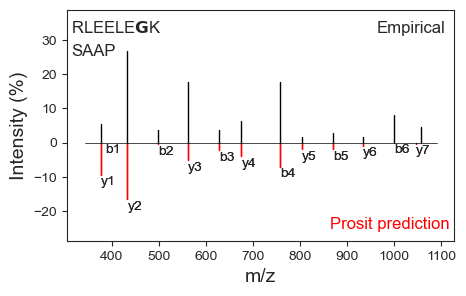

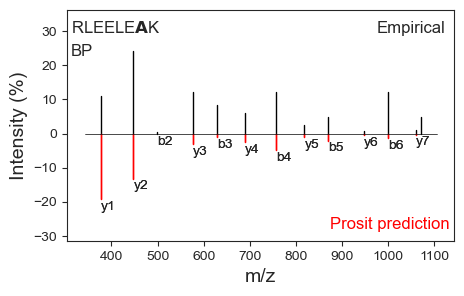

In [11]:
""" Code to generate a mirror plot for given SAAP-BP in given dataset"""

saap = 'RLEELEGK'
bp = 'RLEELEAK'
ds = 'PDAC'

saap_idx = [i for i,x in enumerate(saap) if bp[i]!=x][0]
saap_aa = saap[saap_idx]
bp_aa = bp[saap_idx]

data_dir = data_dir_list[datasets.index(ds)]


predictions = pd.read_csv(data_dir+ds+'_SAAP_predictions.csv', index_col=0)
if ds!='Healthy':
    predictions['SAAP'] = [x[13:] for x in predictions['peptide_sequences']]
else:
    predictions['SAAP'] = predictions['peptide_sequences']
predictions['fragment'] = [x.split('+')[0].split("'")[1] for x in predictions['annotation']]

bp_predictions = pd.read_csv(data_dir+ds+'_BP_predictions.csv', index_col=0)
if ds!='Healthy':
    bp_predictions['BP'] = [x[13:] for x in bp_predictions['peptide_sequences']]
else:
    bp_predictions['BP'] = bp_predictions['peptide_sequences']
bp_predictions['fragment'] = [x.split('+')[0].split("'")[1] for x in bp_predictions['annotation']]


ds_pos_prob_df = pos_prob.loc[pos_prob['Dataset']==ds]
saap_i = ds_pos_prob_df.loc[(ds_pos_prob_df['SAAP']==saap) & (ds_pos_prob_df['BP']==bp)]
saap_i = saap_i.index.to_list()[0]
saap_frags = frag_ion_dict[saap_i]['SAAP']
bp_frags = frag_ion_dict[saap_i]['BP']


meas_int_total = np.sum([int(saap_frags[f]['Intensity']) for f in saap_frags.keys()])
for k,v in saap_frags.items():
    v['Intensity_percent'] = 100*int(v['Intensity'])/meas_int_total
bp_meas_int_total = np.sum([int(bp_frags[f]['Intensity']) for f in bp_frags.keys()])
for k,v in bp_frags.items():
    v['Intensity_percent'] = 100*int(v['Intensity'])/bp_meas_int_total

    
saap_pred = predictions.loc[predictions['SAAP']==saap]
saap_pred.reset_index(inplace=True)
saap_pred = saap_pred.loc[[i for i,row in saap_pred.iterrows() if '+1' in row['annotation']]]
pred_int_total = saap_pred['intensities'].sum()
pred_int_pcnt = [100*x/pred_int_total for x in saap_pred['intensities']]
saap_pred['intensities_percent'] = pred_int_pcnt
if saap[-1]=='K':
    saap_pred['mz'] = [row['mz']+229.162932 if 'y' in row['fragment'] or row['fragment']=='b'+str(len(saap)) else row['mz'] for i,row in saap_pred.iterrows()]

    
bp_pred = bp_predictions.loc[bp_predictions['BP']==bp]
bp_pred.reset_index(inplace=True)
bp_pred = bp_pred.loc[[i for i,row in bp_pred.iterrows() if '+1' in row['annotation']]]
bp_pred_int_total = bp_pred['intensities'].sum()
bp_pred_int_pcnt = [100*x/bp_pred_int_total for x in bp_pred['intensities']]
bp_pred['intensities_percent'] = bp_pred_int_pcnt
if bp[-1]=='K':
    bp_pred['mz'] = [row['mz']+229.162932 if 'y' in row['fragment'] or row['fragment']=='b'+str(len(saap)) else row['mz'] for i,row in bp_pred.iterrows()]

sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(5,3))
for k,v in saap_frags.items():
    x = float(v['Mass'])
    y = v['Intensity_percent']
    plt.plot([x,x], [0,y], color='black', alpha=1, linewidth=1)

for i,row in saap_pred.iterrows():
    intensity = row['intensities_percent']
    mz = float(row['mz'])
    label=row['fragment']

    plt.plot([mz,mz], [0,-intensity], color='red', alpha=1, linewidth=1)
    label_int = intensity+3
    plt.annotate(label, (mz, -(label_int)), fontsize=10)

plt.plot(plt.xlim(), (0,0), 'k', linewidth=0.5)
plt.annotate(saap[:saap_idx]+r'$\mathbf{'+saap_aa+'}$'+saap[saap_idx+1:], (0.01,0.9), xycoords='axes fraction', fontsize=12)
plt.annotate('SAAP', (0.01,0.8), xycoords='axes fraction', fontsize=12)
plt.annotate('Empirical', (0.8,0.9), xycoords='axes fraction', fontsize=12)
plt.annotate('Prosit prediction', (0.68,0.05), xycoords='axes fraction', fontsize=12, color='red')
plt.xlabel('m/z', fontsize=14)
#plt.yticks([])
plt.ylabel('Intensity (%)', fontsize=14)
plt.ylim(plt.ylim()[0]-10, plt.ylim()[1]+10)

#plt.xlim([250,1250])

#plt.savefig(outdir+saap+'_mirror_plot_'+ds+'_'+str(r)+'_SAAP.png', dpi=300, bbox_inches='tight')
plt.savefig(outdir+saap+'_mirror_plot_'+ds+'_SAAP.pdf', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(5,3))
for k,v in bp_frags.items():
    x = float(v['Mass'])
    y = v['Intensity_percent']
    plt.plot([x,x], [0,y], color='black', alpha=1, linewidth=1)

for i,row in bp_pred.iterrows():
    intensity = row['intensities_percent']
    mz = float(row['mz'])
    label=row['fragment']

    plt.plot([mz,mz], [0,-intensity], color='red', alpha=1, linewidth=1)
    label_int = intensity+3
    plt.annotate(label, (mz, -(label_int)), fontsize=10)

plt.plot(plt.xlim(), (0,0), 'k', linewidth=0.5)
plt.annotate(bp[:saap_idx]+r'$\mathbf{'+bp_aa+'}$'+bp[saap_idx+1:], (0.01,0.9), xycoords='axes fraction', fontsize=12)
plt.annotate('BP', (0.01,0.8), xycoords='axes fraction', fontsize=12)
plt.annotate('Empirical', (0.8,0.9), xycoords='axes fraction', fontsize=12)
plt.annotate('Prosit prediction', (0.68,0.05), xycoords='axes fraction', fontsize=12, color='red')
plt.xlabel('m/z', fontsize=14)
#plt.yticks([])
plt.ylabel('Intensity (%)', fontsize=14)
plt.ylim(plt.ylim()[0]-10, plt.ylim()[1]+10)

#plt.xlim([250,1250])

#plt.savefig(outdir+bp+'_mirror_plot_'+ds+'_'+str(r)+'_BP.png', dpi=300, bbox_inches='tight')
plt.savefig(outdir+bp+'_mirror_plot_'+ds+'_BP.pdf', bbox_inches='tight')


### Supplemental Data Figure 3

In [ ]:
# obtained # reads at each RNA base for LSCC dataset using samtools depth (described in Methods) and extracted base positions corresponding to SAAP. 
# The output from this analysis is 'LSCC_SAAP_reads.tsv', read in below

ds = 'LSCC'
lscc_rnaseq_dir = lscc_proj_dir + 'RNAseq_data/'
saap_reads = pd.read_table(lscc_rnaseq_dir+'LSCC_SAAP_reads.tsv', index_col=0)
ds_coord_data =  pd.read_excel(dependencies_dir+'LSCC_coord_data.xlsx') # the output from samtools depth

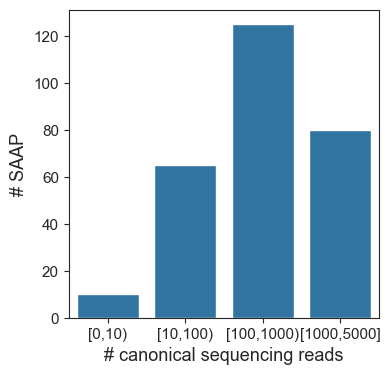

In [ ]:
def read2bin(read):
    """ function to bin # reads for plotting"""
    if read<10:
        read_bin = '[0,10)'
    elif read<100:
        read_bin = '[10,100)'
    elif read<1000:
        read_bin = '[100,1000)'
    else:
        read_bin = '[1000,5000]'
    return(read_bin)


ds_coord_data['read_bin'] = ds_coord_data.apply(lambda x: read2bin(x['# sequencing reads']), axis=1)

# plot # SAAP in each read depth bucket, Supplemental Figure 3a
plot_rows = []
plot_cols = ['# sequencing reads', '# SAAP']

set_read_bins = list(set(ds_coord_data['read_bin'].to_list()))
for read_bin in set_read_bins:
    n_saap = len(ds_coord_data.loc[ds_coord_data['read_bin']==read_bin])
    plot_rows.append([read_bin, n_saap])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

fig,ax = plt.subplots(figsize=(4,4))
sns.barplot(data=plot_df, y='# SAAP', x='# sequencing reads', order=['[0,10)', '[10,100)', '[100,1000)', '[1000,5000]'])
ax.tick_params('both', labelsize=11)
plt.ylabel('# SAAP', fontsize=13)
plt.xlabel('# canonical sequencing reads', fontsize=13)
plt.savefig(outdir+'LSCC_N_saap_read_bins.pdf', bbox_inches='tight')
plt.savefig(outdir+'LSCC_N_saap_read_bins.png',dpi=300, bbox_inches='tight')

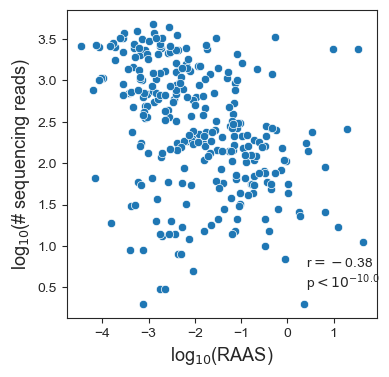

In [36]:
# figure for N reads vs RAAS supplemental Figure 3b

ds_coord_data['log reads'] = [np.log10(x) for x in ds_coord_data['# sequencing reads']]
ds_coord_data = ds_coord_data.loc[ds_coord_data['# sequencing reads']>1]

fig,ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=ds_coord_data, x='RAAS', y='log reads')

plt.xlabel('log$_{10}$(RAAS)', fontsize=13)
plt.ylabel('log$_{10}$(# sequencing reads)', fontsize=13)

corr_data = ds_coord_data.loc[:, ['log reads', 'RAAS']]
corr_data.replace(np.inf, np.nan, inplace=True)
corr_data.replace(-np.inf, np.nan, inplace=True)
corr_data.dropna(how='any', inplace=True)

r,p = sp.stats.pearsonr(corr_data['log reads'], corr_data['RAAS'])
ax.annotate('r$=-$'+str(np.round(np.abs(r),2)), (0.4,0.75))
ax.annotate('p$<10^{'+str(np.ceil(np.log10(p)))+'}$', (0.4,0.5)) 

plt.savefig(outdir+'RAAS_vs_reads.pdf', bbox_inches='tight')
plt.savefig(outdir+'RAAS_vs_reads.png', bbox_inches='tight', dpi=300)